<a href="https://colab.research.google.com/github/ev1025/K-league_Ticketing/blob/main/K_League_Ticketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-League 인천Utd경기장 예매분석

## 가설

- 가설 1 : 게임 순위나 직전 경기결과가 예매에 영향을 미칠 것이다.
- 가설 2 : 고객세분화를 통해 적절한 구매유도 전략을 제시하고 예매를 예측할 수 있다.

## 데이터 전처리

In [ ]:
# 한글 그래프 폰트(런타임재시작)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df1 = pd.read_csv('/content/drive/MyDrive/더케이/membership.csv')      # 고객테이블
df2 = pd.read_csv('/content/drive/MyDrive/더케이/reserve_ticket.csv')  # 티켓
df3 = pd.read_excel('/content/drive/MyDrive/더케이/d95e264436cf42de.xlsx',engine = 'openpyxl',names=['game_date','rank'], header=None) # 일자별 순위

In [5]:
# df4 경기결과 및 관중 수 
# xml파일 인코딩 깨지는 현상 발생 (encode -> decode -> encode 하여 해결)
import xml.etree.ElementTree as ET

tree = ET.parse('/content/drive/MyDrive/더케이/schedule2022120221019212245.xml', parser=ET.XMLParser(encoding='latin1')) 
root = tree.getroot()

# 깨지는 데이터들 인코딩 진행
empty_list = []
for i in root: 
    i.attrib['yoil'] = i.attrib['yoil'].encode('latin-1').decode('euc-kr')
    i.attrib['meet_name'] = i.attrib['meet_name'].encode('latin-1').decode('euc-kr')
    i.attrib['home_team_name'] = i.attrib['home_team_name'].encode('latin-1').decode('euc-kr')
    i.attrib['away_team_name'] = i.attrib['away_team_name'].encode('latin-1').decode('euc-kr')
    i.attrib['game_type_name'] = i.attrib['game_type_name'].encode('latin-1').decode('euc-kr')
    i.attrib['field_name'] = i.attrib['field_name'].encode('latin-1').decode('euc-kr')
    empty_list.append(i.attrib)

In [6]:
# 리스트 안의 dict[{}]를 데이터프레임으로 만들기
empty_df = pd.DataFrame() # 빈 데이터프레임 만들기
for i in empty_list:
    i = pd.DataFrame.from_dict(i, orient='index').T # dict를 dataframe으로 만들기
    empty_df = empty_df.append(i)                   # 각 dataframe을 빈데이터프레임에 추가
df4 = empty_df.reset_index(drop=True)
df4.head()

,meet_year,meet_seq,meet_name,game_id,game_date,yoil,game_time,home_team,home_team_name,home_team_goal,home_team_tk,away_team,away_team_name,away_team_goal,away_team_tk,field_id,field_name,game_type,game_type_name,audience
0,2022,1,하나원큐 K리그1 2022,1,2022/02/19,토,14:00,K05,전북,1,0,K29,수원FC,0,0,71,전주W,21,스플릿일반,7715
1,2022,1,하나원큐 K리그1 2022,2,2022/02/19,토,16:30,K17,대구,0,0,K09,서울,2,0,114,대구전,21,스플릿일반,8082
2,2022,1,하나원큐 K리그1 2022,3,2022/02/19,토,16:30,K18,인천,1,0,K02,수원,0,0,95,인천,21,스플릿일반,5382
3,2022,1,하나원큐 K리그1 2022,4,2022/02/20,일,14:00,K04,제주,0,0,K03,포항,3,0,85,제주W,21,스플릿일반,2514
4,2022,1,하나원큐 K리그1 2022,5,2022/02/20,일,14:00,K21,강원,2,0,K08,성남,0,0,25,강릉,21,스플릿일반,1933


In [7]:
# 잘 저장됐는지 확인
# empty_df.to_csv('/content/drive/MyDrive/더케이/schedule.csv', index=False)
# a = pd.read_csv('/content/drive/MyDrive/더케이/schedule.csv', parse_dates=["game_date"])

### df1

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15878 entries, 0 to 15877
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MB_IDX        15878 non-null  int64  
 1   MB_AGE        15878 non-null  int64  
 2   zipcode       15646 non-null  float64
 3   job           13249 non-null  object 
 4   favorite_idx  15878 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 620.4+ KB


In [9]:
# zipcode가 결측치인 사람들은 job도 모두 결측치, 좋아하는 선수는 무고사로 선택(기본옵션인듯)
df1[df1.zipcode.isna()].groupby('favorite_idx').count()

,MB_IDX,MB_AGE,zipcode,job
favorite_idx,,,,
무고사,232,232,0,0


In [10]:
# zipcode 결측치 0으로 채워줌
# 직업이 결측치인 사람들의 특징을 찾아봤으나 별다른 사항없어서 '기타로 변경'
df1['zipcode'] = df1['zipcode'].fillna(0)
df1['job'] = df1['job'].fillna('기타')

### df2

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53921 entries, 0 to 53920
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   reserve_no                 53921 non-null  int64 
 1   membership_no              53921 non-null  int64 
 2   reserve_datetime           48482 non-null  object
 3   cancel_datetime            5439 non-null   object
 4   game_date                  53921 non-null  object
 5   game_time                  53921 non-null  object
 6   match_info                 53921 non-null  object
 7   reserve_state_code         53921 non-null  object
 8   reserve_detail_no          53921 non-null  int64 
 9   ticket_no                  53921 non-null  int64 
 10  product_grade_name         53921 non-null  object
 11  product_denomination_name  53921 non-null  object
 12  seat_Attribute_4           53921 non-null  object
 13  seat_Attribute_5           53762 non-null  object
 14  seat_A

In [12]:
# 'seat_Attribute_5' 결측치 확인
# 스카이라운지는 열번호가 없어서 sky로 채워줌
df2.loc[df2['seat_Attribute_5'].isna(),'seat_Attribute_5'] = 'sky'

In [13]:
# 예매 취소 컬럼 중복 detail_cancel_date_time컬럼 불필요
a = df2[df2['cancel_datetime'].notna()]['cancel_datetime'] != df2[df2['cancel_datetime'].notna()]['detail_cancel_date_time']
a[a.notna()].unique()

array([False])

In [14]:
# reserve_datetime, cancel_datetime 불필요하게 컬럼2개 사용 -> reserve_time 컬럼으로 병합

# 컬럼 병합
def combine_2rd_columns(col_1, col_2):
    result1 = str(col_1)
    result2 = str(col_2) 
    if not pd.isna(col_1):
        return result1
    else:
        return result2
    

df2["reserve_time"] = df2.apply(lambda x: combine_2rd_columns(x['reserve_datetime'], x['cancel_datetime']), axis=1)

# 티케팅 날짜+시간 시간타입 컬럼 생성
df2['reserve_time'] = pd.to_datetime(df2.loc[:,'reserve_time'], format='%Y-%m-%d %H:%M:%S',errors='raise')

In [15]:
# 게임 날짜+시간  시간타입 컬럼생성
df2['game_now'] = df2['game_date']+' '+ df2['game_time']
df2['game_now'] = pd.to_datetime(df2['game_now'], format='%Y-%m-%d %H:%M:%S')

# 게임 요일정보가 없어서 요일정보 추가
df2['game_yoil'] = df2['game_now'].dt.weekday

df2['game_month'] = df2['game_now'].dt.month

In [16]:
df2.game_date

0        2022-02-19
1        2022-02-19
2        2022-02-19
3        2022-02-19
4        2022-02-19
            ...    
53916    2022-10-16
53917    2022-10-16
53918    2022-10-16
53919    2022-10-16
53920    2022-10-16
Name: game_date, Length: 53921, dtype: object

In [17]:
# 상대팀
away_team = df4[df4['field_name']=='인천'][['game_date','away_team_name']]
away_team.game_date = away_team.game_date.str.replace('/','-')

df2 = pd.merge(df2, away_team, on='game_date')

In [18]:
# 2022년분석이기 때문에 'match_info' 삭제
# 취소정보는 코드로 기록되어있기 때문에 'cancel_yn' 삭제
# 고객 사용시간 컬럼을 통합하였으므로 reserve_datetime, cancel_datetime 삭제
df2.drop(['detail_cancel_date_time','match_info','reserve_datetime', 'cancel_datetime'],axis=1,inplace=True)

In [19]:
# 고객 사용시간(connect_time) 옆에 reserve_state_code 위치 시킴
# df2.columns.tolist()
df2 = df2[['reserve_no',
 'membership_no',
 'game_now',
 'reserve_state_code',
 'reserve_time',
 'reserve_detail_no',
 'ticket_no',
 'product_grade_name',
 'product_denomination_name',
 'seat_Attribute_4',
 'seat_Attribute_5',
 'seat_Attribute_6',
 'game_date',
 'game_time',
 'game_yoil',
 'game_month',
 'away_team_name',
'cancel_yn'
 ]]

### df3

In [20]:
# df3 # 일자별 순위
year_rank = df3[df3['game_date'] > '2022.02.01'].reset_index(drop=True)
# year_rank

### df4

In [21]:
# df4 # 2022년 경기 일정

In [22]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   meet_year       228 non-null    object
 1   meet_seq        228 non-null    object
 2   meet_name       228 non-null    object
 3   game_id         228 non-null    object
 4   game_date       228 non-null    object
 5   yoil            228 non-null    object
 6   game_time       228 non-null    object
 7   home_team       228 non-null    object
 8   home_team_name  228 non-null    object
 9   home_team_goal  222 non-null    object
 10  home_team_tk    222 non-null    object
 11  away_team       228 non-null    object
 12  away_team_name  228 non-null    object
 13  away_team_goal  222 non-null    object
 14  away_team_tk    222 non-null    object
 15  field_id        228 non-null    object
 16  field_name      228 non-null    object
 17  game_type       228 non-null    object
 18  game_type_

In [23]:
df4.dropna(inplace=True,axis=0)

**tk(승부차기) 컬럼 삭제, 연도와 각 팀, 경기장의 id번호 삭제**

In [24]:
df4['home_team_tk'].unique()

array(['0'], dtype=object)

In [25]:
df4['away_team_tk'].unique()

array(['0'], dtype=object)

In [26]:
df4.drop(columns = ['home_team_tk','away_team_tk','meet_year','meet_seq','meet_name','home_team','away_team','field_id'],inplace=True,)

In [27]:
# 숫자데이터 숫자로 변경
df4[['audience','home_team_goal','away_team_goal']] = df4[['audience','home_team_goal','away_team_goal']].astype(int)

# 날짜데이터 datetime변경
df4['game_date'] = pd.to_datetime(df4['game_date'])

df4['yoil'] = df4['yoil'].replace({'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})

## 데이터 분석

In [28]:
# 그래프 설정
plt.rc('font', family='NanumBarunGothic')
plt.rc('font', size=15)
plt.rcParams['axes.unicode_minus'] = False # 마이너스 표시

### 함수

In [29]:
# index, col별 개수
def mk_heat(data, col, idx):
    data_ = data.groupby([col, idx],as_index=False).count().iloc[:,0:3]
    data_pivot = data_.pivot_table(index=idx, columns=col,values=data.columns[0])
    heat = sns.heatmap(data_pivot, annot=True, fmt='.0f',cmap='Blues')
    return heat

In [30]:
# 코호트 주제 : 사용자 유지율 분석
# 첫번째 주문을 토대로 유저별 코호트그룹 설정
def mk_cohort(data,title):
    df_cohort = data[data['reserve_state_code']=='COMPLETE'].copy()

    # 주문 연도-월 컬럼 생성
    df_cohort['game_date'] = pd.to_datetime(df_cohort['game_date'],format='%Y-%m-%d')
    df_cohort['orderperiod'] = df_cohort['game_date'].dt.strftime('%Y-%m')
    df_cohort = df_cohort[['reserve_no','game_date','membership_no','orderperiod']]
    
    # 유저번호별를 인덱스로 지정
    df_cohort.set_index('membership_no',inplace=True)

    # 유저번호별 최초 구매 그룹 생성(시리즈)
    #.dt()는 Series형태에만 사용가능하므로 as_index 사용금지
    firstorder = df_cohort.groupby(df_cohort.index)['game_date'].min()
    firstorder = firstorder.dt.strftime('%Y-%m')
    df_cohort.loc[:,'firstorder'] = firstorder
    df_cohort.reset_index(inplace=True)

    # 월별 순방문자 수(중복 비허용)
    # 3번째 컬럼은 순방문자 수로 이름 변경
    cohorts = df_cohort.groupby(['firstorder','orderperiod'], as_index=False)['membership_no'].nunique()
    cohorts.rename({'membership_no':'Uniquevisitor'}, axis=1, inplace=True)

    # 첫 방문한 월별 이용자의 이용 월( 2월~4월동안 이용했으면 3 , 3월~4월 이면 2, 4월에 처음이면 1)
    # 중간에 아무도 사용하지 않은 월이 있을 경우 밑의 코드로 해당 월을 0으로 채워줘야한다.
    each_period = cohorts['firstorder'].value_counts().sort_index()

    ## each_period에서 비는 부분이 있는 경우 인덱스하나를 추가해서 행을 만들어줌
    # cohorts.loc[cohorts.shape[0], 'firstorder']='2022-03'      # 제일 끝(shape[0])에 컬럼 열 생성
    # cohorts.loc[cohorts.shape[0]-1, 'orderperiod'] = '2022-04' # 길이가 길어졌으므로 shape[0]-1
    # cohorts.loc[cohorts.shape[0]-1, 'Uniquevisitor'] = 0

    # 기간별 레이블링
    cohortperiod = [y for x in each_period for y in range(x)] # 0~8 , 0~7 , 0~6 ...
    cohorts['cohortperiod'] = cohortperiod      

    # 코호트 완성
    # 멀티인덱스에서 unstack()하면 두번째 인덱스가 columns이 된다.
    # index가 최초방문일자
    # 0 = 최초방문, 1 = 두번째 방문
    cohorts.set_index(['firstorder','cohortperiod'], inplace=True)
    cohorts = cohorts.Uniquevisitor.unstack()

    # 고객유지율
    # 첫 순방문자에 비해 각 기간 순방문자가 얼마나 유지되는지여부
    user_retention = cohorts.divide(cohorts[0],axis=0)

    # retention 히트맵
    # 대각선이 유지율
    plt.figure(figsize=(12,8))
    sns.heatmap(user_retention, annot=True, fmt='.0%',cmap='Blues')
    plt.title(title, fontsize=30, pad=20)
    plt.xlabel('이용기간',fontsize=15)
    plt.ylabel('첫 이용 날짜', labelpad=50, fontsize=15, rotation='horizontal')
    plt.show();

### (가설1)경기결과가 예매에 영향을 끼치는가?

- result_h, result_a : 해당 경기 결과
- past_h, past_a : 직전 경기 결과

In [31]:
# 승패 기록하기 홈팀, 원정팀
def game_result(data):
    # 지난 경기 결과
    data['past_h'] = 0 # 홈팀 지난경기
    data['past_a'] = 0 # 원정팀 지난경기

    # 경기 결과 
    data['result_h'] = 0 # 홈팀 결과
    data['result_a'] = 0 # 원정팀 결과

    # 경기결과
    # 승리 : 1 , 패배 :-1 , 무승부 : 0
    for i in range(len(data)):
        if data.loc[i,'home_team_goal'] > data.loc[i,'away_team_goal']:
            data.loc[i,'result_h'] = 1
            data.loc[i,'result_a'] = -1
        elif data.loc[i,'home_team_goal'] < data.loc[i,'away_team_goal']:
            data.loc[i,'result_h'] = -1
            data.loc[i,'result_a'] = 1
    return data

game_result(df4);

In [32]:
# 팀별 직전 경기 결과 수정을 위해 인덱스 저장
def index_save(data, team):
    home_index = data[data['home_team_name']==team].index
    away_index = data[data['away_team_name']==team].index
    all_index = data[(data['home_team_name']==team)|(data['away_team_name']==team)].index
    return home_index, away_index, all_index

In [33]:
# 직전 경기결과 컬럼을 삽입하는 함수(past_h, past_a)
def past_result(data,team):
    
    # 직전 경기의 shift진행을 위해 분류 및 인덱스 초기화
    sample = data[(data['home_team_name']==team) | (data['away_team_name']==team)].reset_index(drop=True)

    # 결과 기록할 컬럼 생성
    sample['result'] = 0 
    
    # 결과기록
    # 첫경기는 직전경기가 없어서 1부터 시작[1:]
    # 직전 경기 결과를 저장하기 위해 [i-1]
    # 승리 = 1, 패배 = -1 , 무승부 = 0
    for i in range(len(sample))[1:]:
        if (sample.loc[i-1,'home_team_name'] == team)&(sample.loc[i-1, 'result_h']==1):
            sample.loc[i,'result'] = 1
        elif (sample.loc[i-1, 'home_team_name']== team)&(sample.loc[i-1, 'result_h']==-1):
            sample.loc[i,'result'] = -1
        elif (sample.loc[i-1, 'away_team_name'] == team) & (sample.loc[i-1, 'result_a']==1):
            sample.loc[i,'result'] = 1
        elif (sample.loc[i-1,'away_team_name'] == team) & (sample.loc[i-1, 'result_a']==-1):
            sample.loc[i,'result'] = -1
        elif (sample.loc[i-1,'result_a']==0):
            sample.loc[i,'result'] = 0
    
    # 결과기록 완료 후 인덱스 재지정(위에 만든 index_save함수)
    home_index, away_index, sample.index = index_save(data, team)

    # 인덱스별로 직전경기 결과를 past_컬럼에 넣기
    data.loc[home_index,'past_h'] = sample.loc[home_index,'result']
    data.loc[away_index,'past_a'] = sample.loc[away_index,'result']

    return sample

In [34]:
# 직전 결과 함수 적용
for i in df4.away_team_name.unique():
    past_result(df4, i)

# 결과 확인
df4.iloc[:,[4,5,6,7,12,13,14,15]].head()

,home_team_name,home_team_goal,away_team_name,away_team_goal,past_h,past_a,result_h,result_a
0,전북,1,수원FC,0,0,0,1,-1
1,대구,0,서울,2,0,0,-1,1
2,인천,1,수원,0,0,0,1,-1
3,제주,0,포항,3,0,0,-1,1
4,강원,2,성남,0,0,0,1,-1


**직전 경기 결과가 예매에 영향을 주는가?**
- 인천 경기장과 전체 경기장의 추이를 분석
- 직전 경기결과는 관계가 없어보임

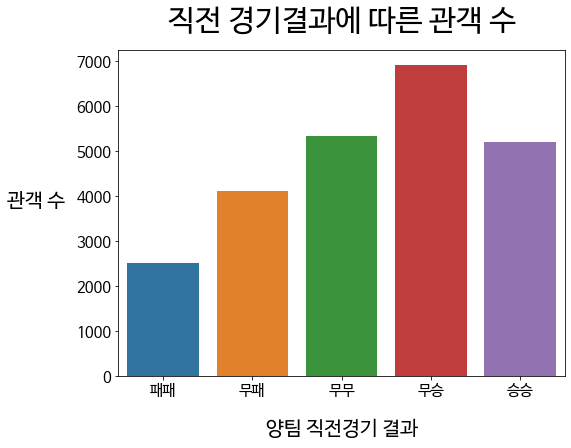

In [35]:
# 인천경기장 기준 직전 경기의 승패가 예매에 영향을 주는지
# -2 : 두팀 모두 직전경기 패배 / 2 : 두팀 모두 직전경기 승리
in_df4 = df4[df4['field_name']=='인천']

past_df = in_df4.loc[:,['away_team_name','home_team_name', 'audience']]
past_df['score'] = df4[df4['field_name']=='인천']['past_h'] + df4[df4['field_name']=='인천']['past_a']

past_df_bar = past_df.groupby('score',as_index=False).mean()[['score','audience']]
plt.figure(figsize=(8,6))
sns.barplot(data= past_df_bar, x= 'score', y='audience')
plt.title('직전 경기결과에 따른 관객 수',pad=20, fontsize=30)
plt.xlabel('양팀 직전경기 결과',fontsize=20, labelpad =20)
plt.ylabel('관객 수', fontsize=20, labelpad =40, rotation='horizontal')
plt.xticks(range(5),['패패','무패','무무','무승','승승'])
plt.show();

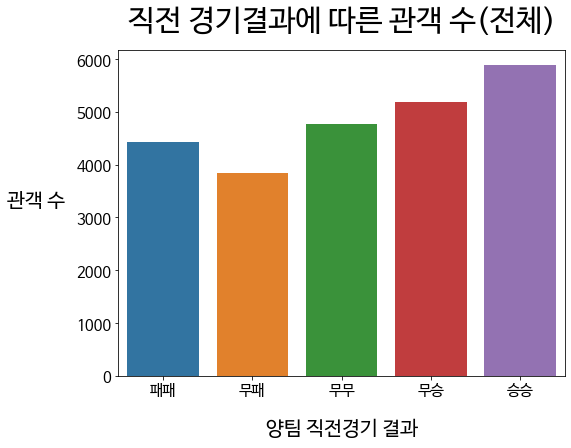

In [36]:
# 인천경기장에만 해당되는 것인지 궁금하여
# 전체 경기장장에서 직전 경기의 승패가 예매에 영향을 주는지 비교

past_df_all = df4.loc[:,['away_team_name','home_team_name', 'audience']]
past_df_all['all_score'] = df4['past_h'] + df4['past_a']

past_df_all_bar = past_df_all.groupby('all_score',as_index=False).mean()[['all_score','audience']]
plt.figure(figsize=(8,6))
sns.barplot(data= past_df_all_bar, x= 'all_score', y='audience')
plt.title('직전 경기결과에 따른 관객 수(전체)',pad=20, fontsize=30)
plt.xlabel('양팀 직전경기 결과',fontsize=20, labelpad =20)
plt.ylabel('관객 수', fontsize=20, labelpad =40, rotation='horizontal')
plt.xticks(range(5),['패패','무패','무무','무승','승승'])
plt.show();

**팀별 직전경기 점수**
- 인천 경기장 기준 직전경기 점수(past_h, past_a) 합계 그래프
- 직전경기 점수가 높다고 관객 수가 많지는 않음
- 하지만 직전 경기 결과가 좋지 않은 팀의 관객 수가 낮은 점은 확인

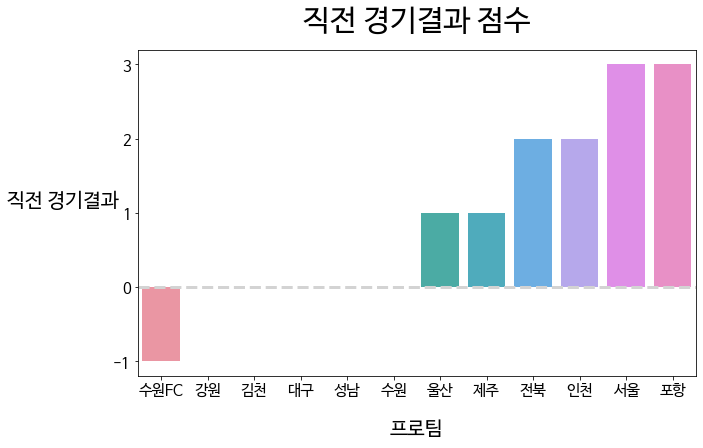

In [37]:
in_away = in_df4.groupby('away_team_name',as_index=False)[['away_team_name','past_h']].sum()
in_home = in_df4.groupby('away_team_name',as_index=False)[['away_team_name','past_a']].sum()
in_score = in_df4.loc[in_df4['home_team_name']=='인천', 'past_h'].sum()

past_rank = in_away.copy()
past_rank['past_h'] = in_away['past_h'] + in_home['past_a']
past_rank.loc[11] = ['인천', in_score]
past_rank.sort_values(by='past_h',inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(data= past_rank, x='away_team_name', y='past_h')
plt.title('직전 경기결과 점수',pad=20, fontsize=30)
plt.xlabel('프로팀',fontsize=20, labelpad =20)
plt.ylabel('직전 경기결과', fontsize=20, labelpad =50, rotation='horizontal')
plt.yticks(range(-1,4))
plt.axhline( color='lightgray', linestyle='--', linewidth=3)
plt.show();

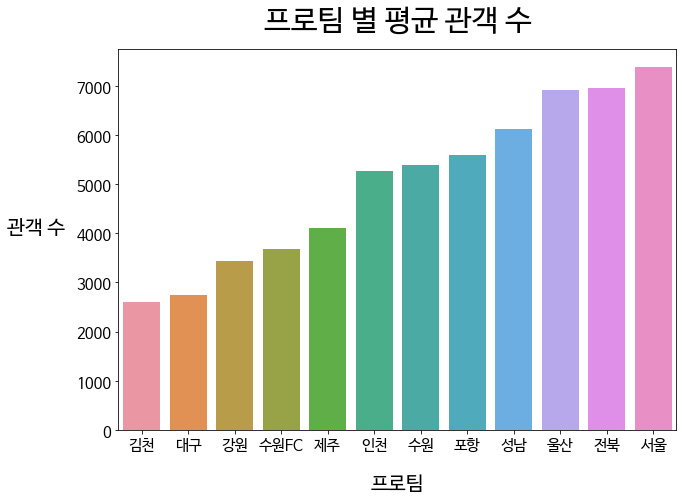

In [38]:
# 직전 경기결과 하위 4개팀의 관객수가 낮음
past_df_audi = past_df.groupby('away_team_name',as_index=False)[['away_team_name','audience']].mean()
past_df_audi.loc[11] = ['인천', past_df.audience.mean()]
past_df_audi.sort_values(by='audience',inplace = True)

plt.figure(figsize=(10,7))
sns.barplot(data= past_df_audi, x='away_team_name', y='audience')
plt.title('프로팀 별 평균 관객 수',pad=20, fontsize=30)
plt.xlabel('프로팀',fontsize=20, labelpad =20)
plt.ylabel('관객 수', fontsize=20, labelpad =40, rotation='horizontal')
plt.show();

### (가설1)인천유나이티드 순위가 관객 수에 영향을 끼칠까?

- 순위가 높다고 관객이 많지는 않음
- 순위 변동에 따라 관객수가 달라지는 경향을 보임

In [39]:
# 인천팀 홈경기에 게임별 순위 merge
in_df = pd.merge(df4[(df4['home_team_name']=='인천')], df3, how='inner', on = 'game_date')

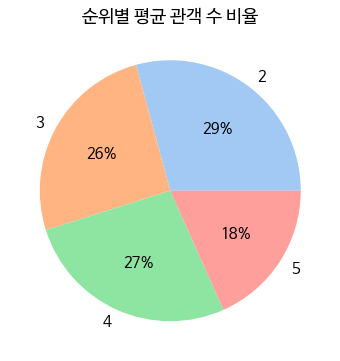

In [40]:
# 인천팀 순위별 평균 관객 수
in_rank = in_df.groupby('rank',as_index=False)['audience'].mean().sort_values(by='rank').round().astype(int)

# 인천팀 순위별 평균 관객 수 비율
plt.figure(figsize=(10,6))
plt.pie(x=in_rank['audience'],labels=in_rank['rank'],colors=sns.color_palette('pastel'), autopct='%.0f%%')
plt.title('순위별 평균 관객 수 비율')
plt.show();

[]

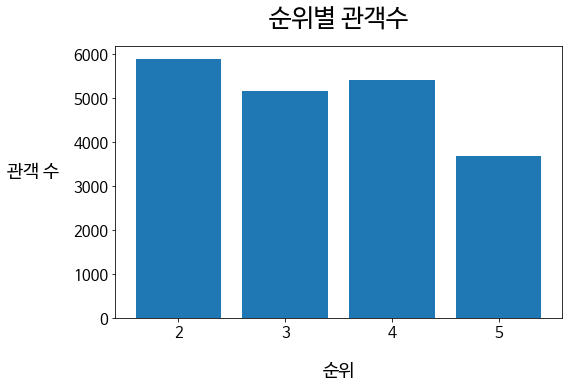

In [41]:
rank_audi_mean = in_df.groupby('rank',as_index=False)[['rank','audience']].mean().round().astype(int)

plt.figure(figsize=(8,5))
plt.bar(rank_audi_mean['rank'], rank_audi_mean['audience'])
plt.xticks(range(6))
plt.title('순위별 관객수',pad=20, fontsize=25)
plt.ylabel('관객 수', rotation='horizontal', labelpad=40, fontsize=18)
plt.xlabel('순위', rotation='horizontal', labelpad=20, fontsize=18)
plt.plot()

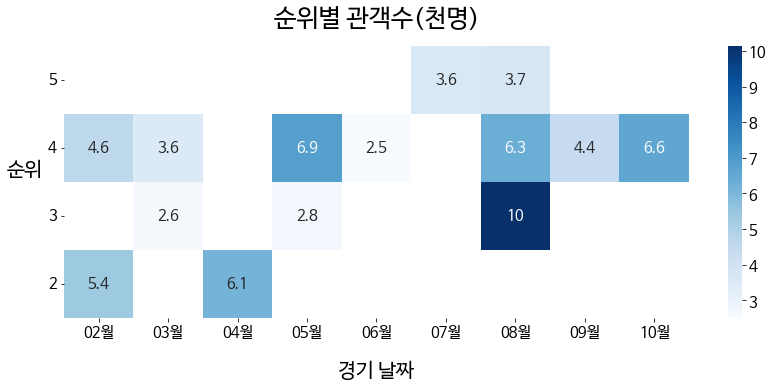

In [42]:
# 월별 순위별 관객 수로 나눠서 보자
in_df['month'] = in_df['game_date'].dt.strftime('%m')
in_mon = in_df.groupby(['month','rank'],as_index=False)[['audience']].mean().round()

# 각 데이터 접미사 추가
# in_mon['rank'] = in_mon['rank'].astype('str') + '위'
in_mon['month'] = in_mon['month'].astype('str') + '월'

# 히트맵을 위한 피벗테이블
in_pivot = in_mon.pivot_table(columns='month',index='rank',values='audience', aggfunc=lambda x : x/1000)
in_pivot = in_pivot.reset_index()
in_pivot.sort_values(by='rank',ascending=False,inplace=True)
in_pivot = in_pivot.set_index('rank')

plt.figure(figsize=(14,5))
sns.heatmap(in_pivot, annot=True,cmap='Blues')
plt.title('순위별 관객수(천명)',pad=20, fontsize=25)
plt.ylabel('순위', rotation='horizontal', labelpad=23, fontsize=20)
plt.xlabel('경기 날짜', rotation='horizontal', labelpad=20, fontsize=20)
plt.yticks(rotation='horizontal')
plt.show();

### 인천 경기장 요일별 관객, 경기 수

- 주로 화요일, 토요일, 일요일 경기가 많음
- 관객 수는 토요일 > 일요일 > 화요일

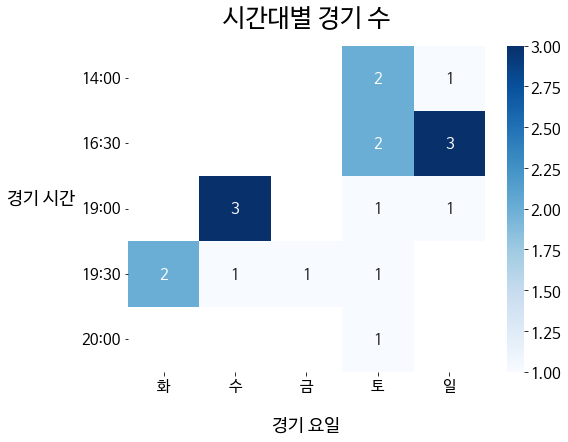

In [43]:
# 인천경기장 경기 수
in_field = df4[df4['field_name']=='인천']

plt.figure(figsize=(8,6))
mk_heat(in_field,'yoil','game_time')
plt.title('시간대별 경기 수',pad = 20,fontsize=25)
plt.xticks(np.linspace(0.5, 4.5,5), ['화','수','금','토','일'])
plt.yticks(np.linspace(0.5, 4.5,5), ['14:00','16:30','19:00','19:30','20:00'],rotation= 'horizontal')
plt.ylabel('경기 시간', fontsize=18, labelpad=40, rotation='horizontal')
plt.xlabel('경기 요일', fontsize=18, labelpad=20)
plt.show();

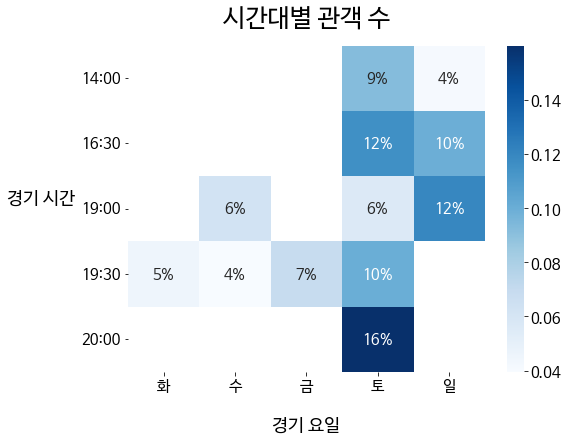

In [44]:
# 인천경기장 관객 수
in_audience = in_field['audience'].sum()
in_audi_pivot = in_field.pivot_table(index = 'game_time',columns='yoil',values='audience', aggfunc=['mean'])

in_audi_user = in_audi_pivot.sum().sum()
in_audi_pivot = (in_audi_pivot/in_audi_user)

plt.figure(figsize=(8,6))
sns.heatmap(in_audi_pivot, annot=True, fmt='.0%', cmap='Blues')

plt.title('시간대별 관객 수',pad = 20,fontsize=25)
plt.xticks(np.linspace(0.5, 4.5,5), ['화','수','금','토','일'])
plt.yticks(np.linspace(0.5, 4.5,5), ['14:00','16:30','19:00','19:30','20:00'],rotation= 'horizontal')
plt.ylabel('경기 시간', fontsize=18, labelpad=40, rotation='horizontal')
plt.xlabel('경기 요일', fontsize=18, labelpad=20)
plt.show();

### 월별 순 방문자 리텐션 코호트분석(df2)

- 중간에 코로나로 제한이 되었던 시기를 제외하고 비슷한 리텐션을 보임임
- 시즌 초반에 경기장에 방문했던 고객들이 리텐션도 좋음

In [45]:
# 주문 연도-월 컬럼 생성
df_cohort = df2[df2['reserve_state_code']=='COMPLETE'].copy()
df_cohort['game_date'] = pd.to_datetime(df_cohort['game_date'],format='%Y-%m-%d')
df_cohort['orderperiod'] = df_cohort['game_date'].dt.strftime('%Y-%m')
df_cohort = df_cohort[['reserve_no','game_date','membership_no','orderperiod']]
df_cohort.head()

,reserve_no,game_date,membership_no,orderperiod
819,1427279220,2022-02-19,102806,2022-02
820,1427279256,2022-02-19,138160,2022-02
821,1427279256,2022-02-19,138160,2022-02
822,1427279256,2022-02-19,138160,2022-02
823,1427279348,2022-02-19,104910,2022-02


In [46]:
# 코호트 주제 : 사용자 유지율 분석
# 첫번째 주문을 토대로 유저별 코호트그룹 설정
df_cohort.set_index('membership_no',inplace=True)
df_cohort.head()

,reserve_no,game_date,orderperiod
membership_no,,,
102806,1427279220,2022-02-19,2022-02
138160,1427279256,2022-02-19,2022-02
138160,1427279256,2022-02-19,2022-02
138160,1427279256,2022-02-19,2022-02
104910,1427279348,2022-02-19,2022-02


In [47]:
# 멤버십 별 첫 주문 일자
#.dt()는 Series형태에만 사용가능하므로 as_index 사용금지
firstorder =df_cohort.groupby(df_cohort.index)['game_date'].min()
firstorder.head()

membership_no
137   2022-05-29
153   2022-02-19
180   2022-05-08
208   2022-02-19
291   2022-03-13
Name: game_date, dtype: datetime64[ns]

In [48]:
firstorder  = firstorder.dt.strftime('%Y-%m')
firstorder.head()

membership_no
137    2022-05
153    2022-02
180    2022-05
208    2022-02
291    2022-03
Name: game_date, dtype: object

In [49]:
df_cohort['firstorder'] = firstorder
df_cohort.reset_index(inplace=True)
firstorder.head()

membership_no
137    2022-05
153    2022-02
180    2022-05
208    2022-02
291    2022-03
Name: game_date, dtype: object

In [50]:
# 코호트분석은 월별 방문자의 방문자 수 MV(Monthly Visitor)를 구할 것이 아니라 (방문자별 월별 방문 횟수)
# 월별 순 방문자 수 UV(Monthly Unique Visitor)인 방문 여부를 구해야 한다 (월별 방문 여부)
grouped = df_cohort.groupby(['firstorder','orderperiod'])

cohorts = grouped['membership_no'].nunique()
cohorts.head()

# 첫방문, 방문월, 2월에 방문한적 있는 사람(UV) = 1733 전체 방문자 수가 아님
# 2월에 첫 방문후, 3월에 방문한 적이 있는 사람(UV) = 744

firstorder  orderperiod
2022-02     2022-02        1530
            2022-03         564
            2022-04         655
            2022-05         619
            2022-06         237
Name: membership_no, dtype: int64

In [51]:
cohorts = cohorts.reset_index()
cohorts.rename({'membership_no':'Uniquevisitor'}, axis=1, inplace=True)
cohorts.head()

,firstorder,orderperiod,Uniquevisitor
0,2022-02,2022-02,1530
1,2022-02,2022-03,564
2,2022-02,2022-04,655
3,2022-02,2022-05,619
4,2022-02,2022-06,237


In [52]:
# y축 길이 숫자가 순서대로 나와야함(9 8 7 6 5 4 3 2 1)
# 1씩 적어지지 않으면 밑에 셀로 보충해줄 것(9 7 7 6 5 4 3 2 1 이런식이면)
# 데이터가 없는 경우에 발생하며, 0으로 채워줘야함
each_period = cohorts['firstorder'].value_counts().sort_index()
each_period

2022-02    9
2022-03    8
2022-04    7
2022-05    6
2022-06    5
2022-07    4
2022-08    3
2022-09    2
2022-10    1
Name: firstorder, dtype: int64

In [53]:
# 기간별 레이블 붙이기
cohortperiod = [y for x in each_period for y in range(x)] # 0~8 , 0~7 , 0~6 ...
cohorts['cohortperiod'] = cohortperiod
cohorts.head()

,firstorder,orderperiod,Uniquevisitor,cohortperiod
0,2022-02,2022-02,1530,0
1,2022-02,2022-03,564,1
2,2022-02,2022-04,655,2
3,2022-02,2022-05,619,3
4,2022-02,2022-06,237,4


In [54]:
cohorts.set_index(['firstorder','cohortperiod'], inplace=True)
cohorts.head()

orderperiod  Uniquevisitor
firstorder cohortperiod                           
2022-02    0                2022-02           1530
           1                2022-03            564
           2                2022-04            655
           3                2022-05            619
           4                2022-06            237

In [55]:
# 멀티인덱스에서 unstack()하면 두번째 인덱스가 columns이 된다.
# index가 최초방문일자
# 0 최초방문자
# 1 최초방문 후 두번째 방문한 순인원
cohorts = cohorts.Uniquevisitor.unstack()
cohorts

cohortperiod,0,1,2,3,4,5,6,7,8
firstorder,,,,,,,,,
2022-02,1530.0,564.0,655.0,619.0,237.0,238.0,604.0,452.0,628.0
2022-03,512.0,152.0,154.0,44.0,44.0,140.0,92.0,147.0,NaN
2022-04,1028.0,263.0,58.0,44.0,224.0,124.0,234.0,NaN,NaN
2022-05,1016.0,58.0,78.0,189.0,117.0,207.0,NaN,NaN,NaN
2022-06,114.0,25.0,31.0,27.0,29.0,NaN,NaN,NaN,NaN
2022-07,205.0,48.0,37.0,37.0,NaN,NaN,NaN,NaN,NaN
2022-08,1311.0,197.0,304.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-09,427.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10,1071.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# 각 월별 최초방문자
cohorts[0]

firstorder
2022-02    1530.0
2022-03     512.0
2022-04    1028.0
2022-05    1016.0
2022-06     114.0
2022-07     205.0
2022-08    1311.0
2022-09     427.0
2022-10    1071.0
Name: 0, dtype: float64

In [57]:
# 고객유지율
# 첫 순방문자에 비해 각 기간 순방문자가 얼마나 유지되는지여부
user_retention = cohorts.divide(cohorts[0],axis=0)
user_retention

cohortperiod,0,1,2,3,4,5,6,7,8
firstorder,,,,,,,,,
2022-02,1.0,0.368627,0.428105,0.404575,0.154902,0.155556,0.394771,0.295425,0.410458
2022-03,1.0,0.296875,0.300781,0.085938,0.085938,0.273438,0.179688,0.287109,NaN
2022-04,1.0,0.255837,0.056420,0.042802,0.217899,0.120623,0.227626,NaN,NaN
2022-05,1.0,0.057087,0.076772,0.186024,0.115157,0.203740,NaN,NaN,NaN
2022-06,1.0,0.219298,0.271930,0.236842,0.254386,NaN,NaN,NaN,NaN
2022-07,1.0,0.234146,0.180488,0.180488,NaN,NaN,NaN,NaN,NaN
2022-08,1.0,0.150267,0.231884,NaN,NaN,NaN,NaN,NaN,NaN
2022-09,1.0,0.262295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


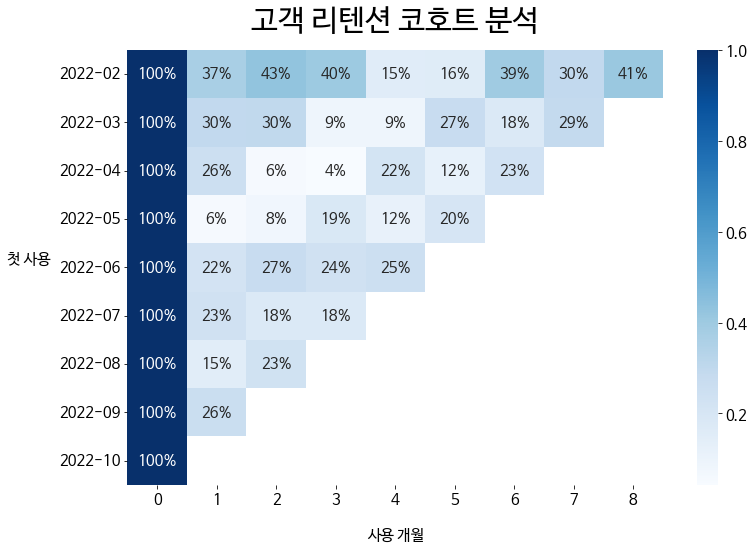

In [58]:
# 고객 리텐션
plt.figure(figsize=(12,8))
sns.heatmap(user_retention, annot=True, fmt='.0%',cmap='Blues')
plt.title('고객 리텐션 코호트 분석', pad= 20, fontsize=30)
plt.ylabel('첫 사용', labelpad = 30, rotation='horizontal')
plt.xlabel('사용 개월', labelpad = 20)
plt.show();

### 1인당 예매 횟수


- 보통 1인당 5회 미만으로 경기장을을 이용하는 경우가 많다.
- 기존고객의 주요고객 전환이 필요하므로 매년 5회 이상 방문을 목표로 구매유도정책 필요

In [59]:
# merge를 위해서 컬럼명 변경
df1 = df1.rename(columns=({'MB_IDX':'membership_no'}))
df2 = pd.merge(df2,df1,on='membership_no')

In [60]:
# 티켓 예매건, 취소건으로 나눔
can_tk = df2[(df2['reserve_state_code']!='COMPLETE')&(df2['cancel_yn']=='Y')] # 티켓 취소건
com_tk = df2[(df2['reserve_state_code']=='COMPLETE')&(df2['cancel_yn']=='N')] # 티켓 예매건

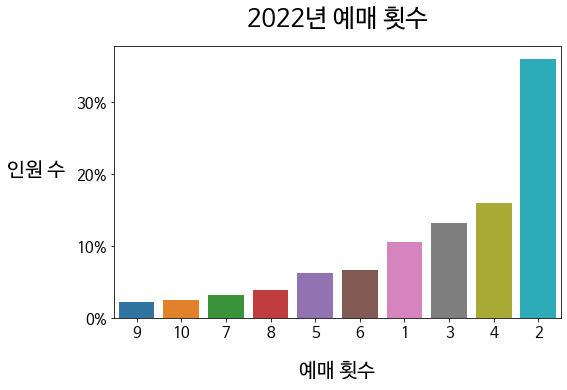

In [61]:
com_num = com_tk.groupby(['membership_no'],as_index=False)[['reserve_detail_no']].count()
com_num_graph = com_num.groupby('reserve_detail_no',as_index=False)[['membership_no']].count().sort_values(by='membership_no')[-10:].reset_index()
com_num_graph['membership_no'] = com_num_graph['membership_no']/com_num_graph['membership_no'].sum()

plt.figure(figsize=(8,5))
sns.barplot(data = com_num_graph, x=com_num_graph.index ,y='membership_no')
plt.title('2022년 예매 횟수',pad=20, fontsize=25)
plt.xlabel('예매 횟수',fontsize=20, labelpad =20)
plt.ylabel('인원 수', fontsize=20, labelpad =40, rotation='horizontal')
plt.yticks(np.arange(0,0.4,0.1), ['0%', '10%','20%','30%'])
plt.xticks(range(len(com_num_graph)), com_num_graph['reserve_detail_no'])
plt.show();

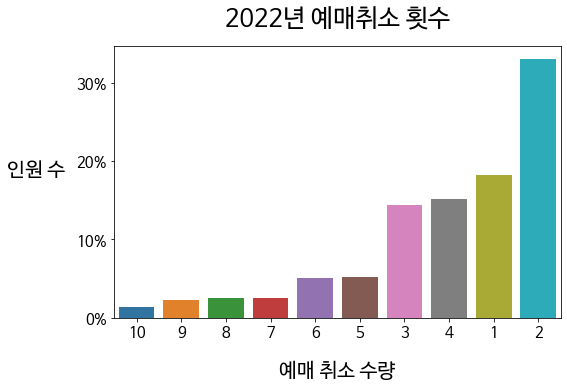

In [62]:
# 티켓취소 데이터
# 마찬가지로 5회 미만이 가장 많음
can_num = can_tk.groupby('membership_no',as_index=False)[['reserve_detail_no']].count() # 멤버별 취소 수량 합계
can_num_graph = can_num.groupby('reserve_detail_no',as_index=False)[['membership_no']].count().sort_values(by='membership_no')[-10:].reset_index()
can_num_graph['membership_no'] = can_num_graph['membership_no']/can_num_graph['membership_no'].sum()

plt.figure(figsize=(8,5))
sns.barplot(data = can_num_graph, x=can_num_graph.index, y='membership_no')
plt.title('2022년 예매취소 횟수',pad=20, fontsize=25)
plt.xlabel('예매 취소 수량',fontsize=20, labelpad =20)
plt.ylabel('인원 수', fontsize=20, labelpad =40, rotation='horizontal')
plt.yticks(np.arange(0,0.4,0.1),['0%', '10%','20%','30%'])
plt.xticks(range(len(can_num_graph)), can_num_graph['reserve_detail_no'])
plt.show();

### 인기 좌석

**좌석 관련정보**
- S : 홈 응원석
- N : 원정 응원석
- E : 일반좌석
- W : 고급좌석   
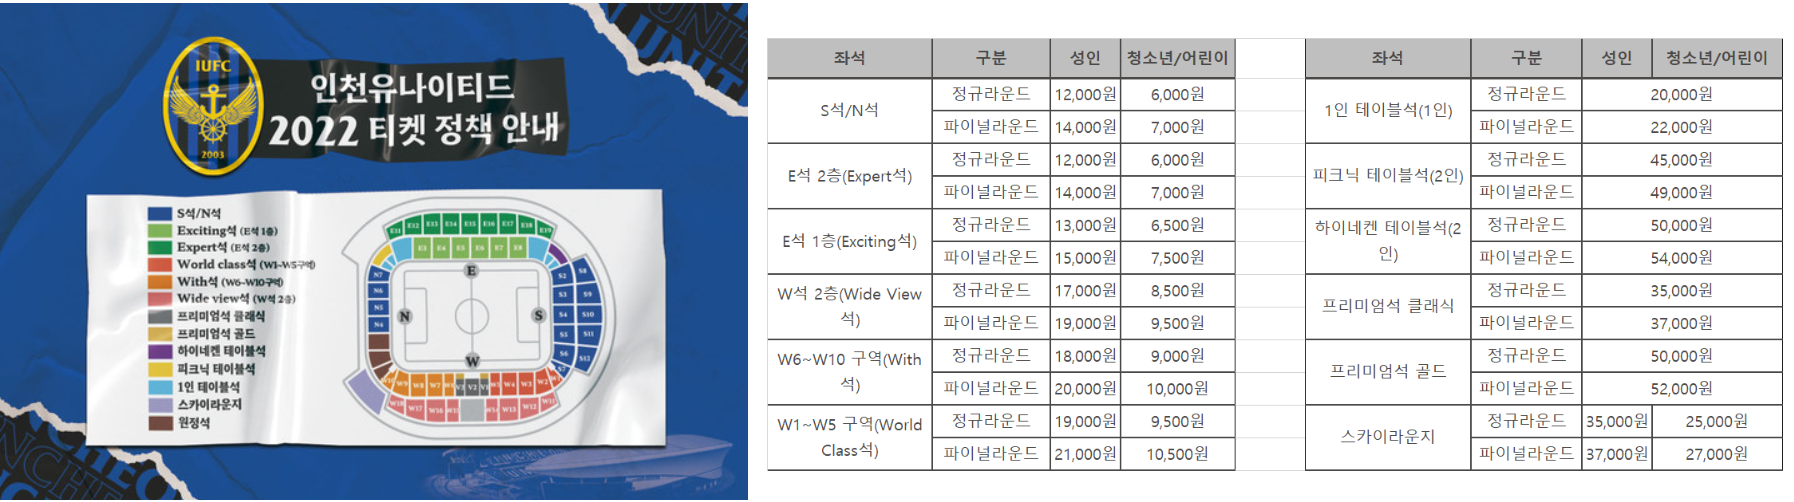

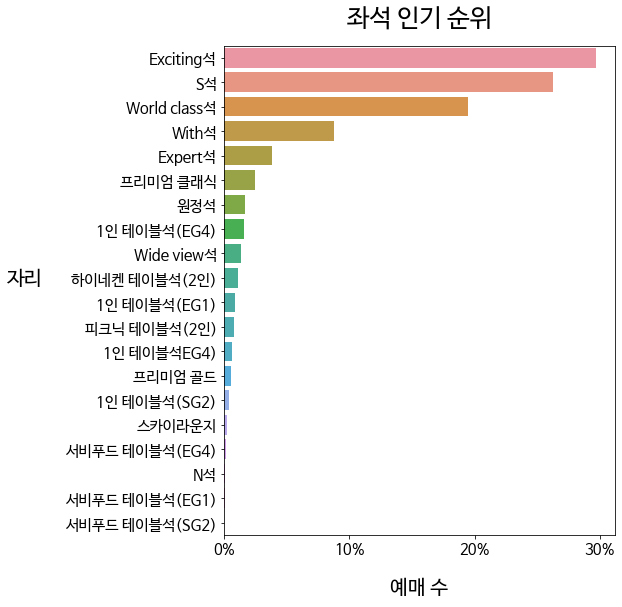

In [63]:
# 예매가 많이 이루어지는 좌석
complete_product = com_tk.groupby('product_grade_name',as_index=False)[['reserve_detail_no']].sum().sort_values(by='reserve_detail_no',ascending=False)
complete_product['reserve_detail_no'] = complete_product['reserve_detail_no']/complete_product['reserve_detail_no'].sum()

plt.figure(figsize=(7,9))
plt.title('좌석 인기 순위', pad=20, fontsize=25)
sns.barplot(data = complete_product, x='reserve_detail_no', y='product_grade_name')
plt.xlabel('예매 수',fontsize=20, labelpad =20)
plt.ylabel('자리', fontsize=20, labelpad =40, rotation='horizontal')
plt.xticks(np.arange(0,0.4,0.1), ['0%', '10%','20%','30%'])
plt.show();

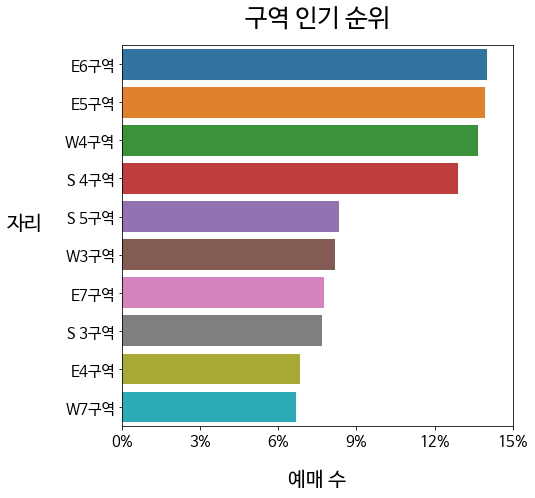

In [64]:
# 예매가 많이 이루어지는 구역
complete_area = com_tk.groupby(['product_grade_name','seat_Attribute_4'],as_index=False)[['reserve_detail_no']].sum().sort_values(by='reserve_detail_no',ascending=False)[:10]
complete_area['reserve_detail_no'] = complete_area['reserve_detail_no']/complete_area['reserve_detail_no'].sum()
plt.figure(figsize=(7,7))
plt.title('구역 인기 순위', pad=20, fontsize=25)
sns.barplot(data = complete_area, x='reserve_detail_no', y='seat_Attribute_4')
plt.xlabel('예매 수',fontsize=20, labelpad =20)
plt.ylabel('자리', fontsize=20, labelpad =40, rotation='horizontal')
plt.xticks(np.arange(0,0.16, 0.03),['0%','3%','6%','9%','12%','15%'])
plt.show();

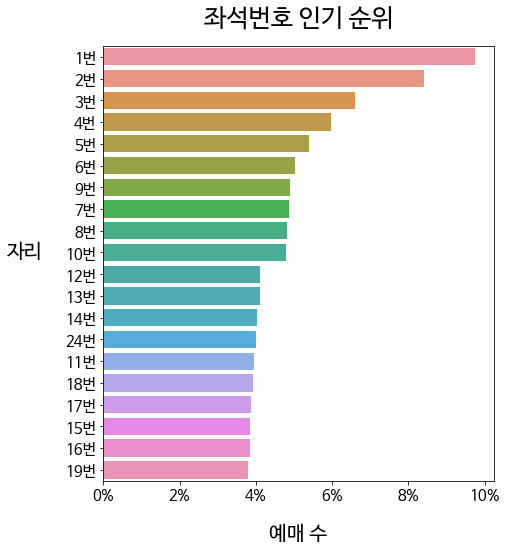

In [65]:
# 좌석번호 인기 순위
complete_seat = com_tk.groupby(['seat_Attribute_6'],as_index=False)[['reserve_detail_no']].count().sort_values(by='reserve_detail_no',ascending=False)[:20]
complete_seat['reserve_detail_no'] = complete_seat['reserve_detail_no']/complete_seat['reserve_detail_no'].sum()

plt.figure(figsize=(7,8))
plt.title('좌석번호 인기 순위', pad=20, fontsize=25)
sns.barplot(data = complete_seat, x='reserve_detail_no', y='seat_Attribute_6')
plt.xlabel('예매 수',fontsize=20, labelpad =20)
plt.ylabel('자리', fontsize=20, labelpad =40, rotation='horizontal')
plt.xticks(np.arange(0,0.12,0.02),['0%','2%','4%','6%','8%','10%'])
plt.show();

**인기좌석(검은색표시)**

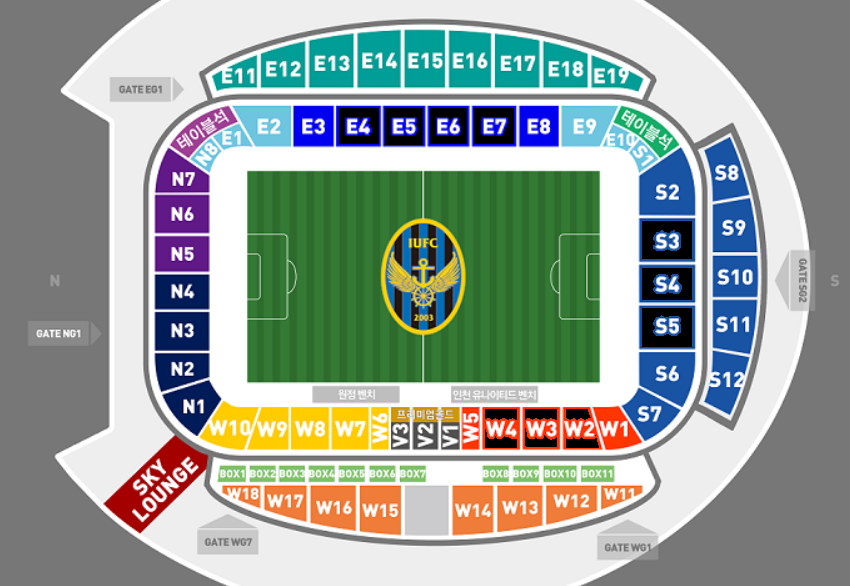

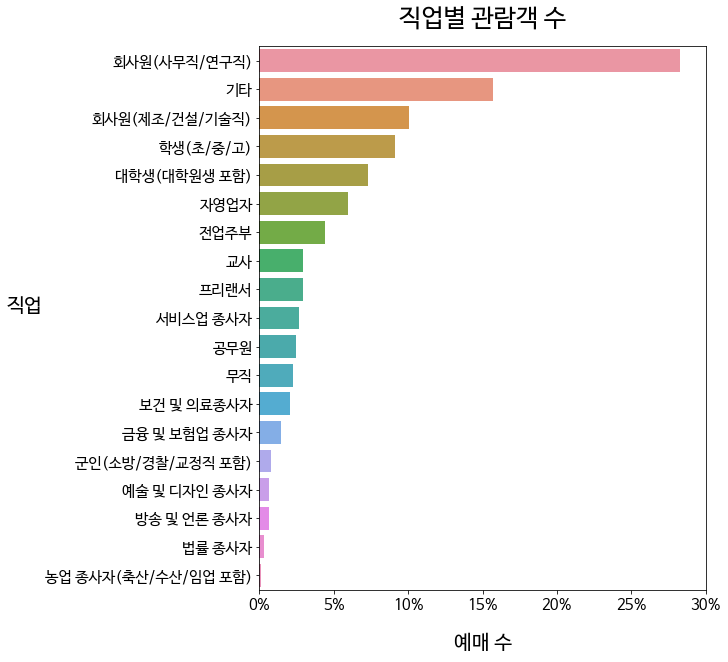

In [66]:
# 직업은 회사원 비중이 높음
com_job_all = df2.groupby('job').count()[['reserve_no']].sort_values(by='reserve_no',ascending=False)
com_job_all['reserve_no'] = com_job_all['reserve_no']/com_job_all['reserve_no'].sum()

plt.figure(figsize=(8,10))
plt.title('직업별 관람객 수', pad=20, fontsize=25)
sns.barplot(data = com_job_all, x='reserve_no', y =com_job_all.index, )
plt.xlabel('예매 수',fontsize=20, labelpad =20)
plt.ylabel('직업', fontsize=20, labelpad =20, rotation='horizontal')
plt.xticks(np.arange(0,0.31,0.05),['0%','5%','10%','15%','20%','25%','30%'])
plt.show();

**Top4좌석의 연령별 예매상품**
- 70~80대 중반에서 청소년/어린이요금제가 많이 결제되었다.
- 자녀가 있는 고객군으로 유추되어 가족관람(단체할인)이나 청소년요금 관련 할인제공하여 구매 유도

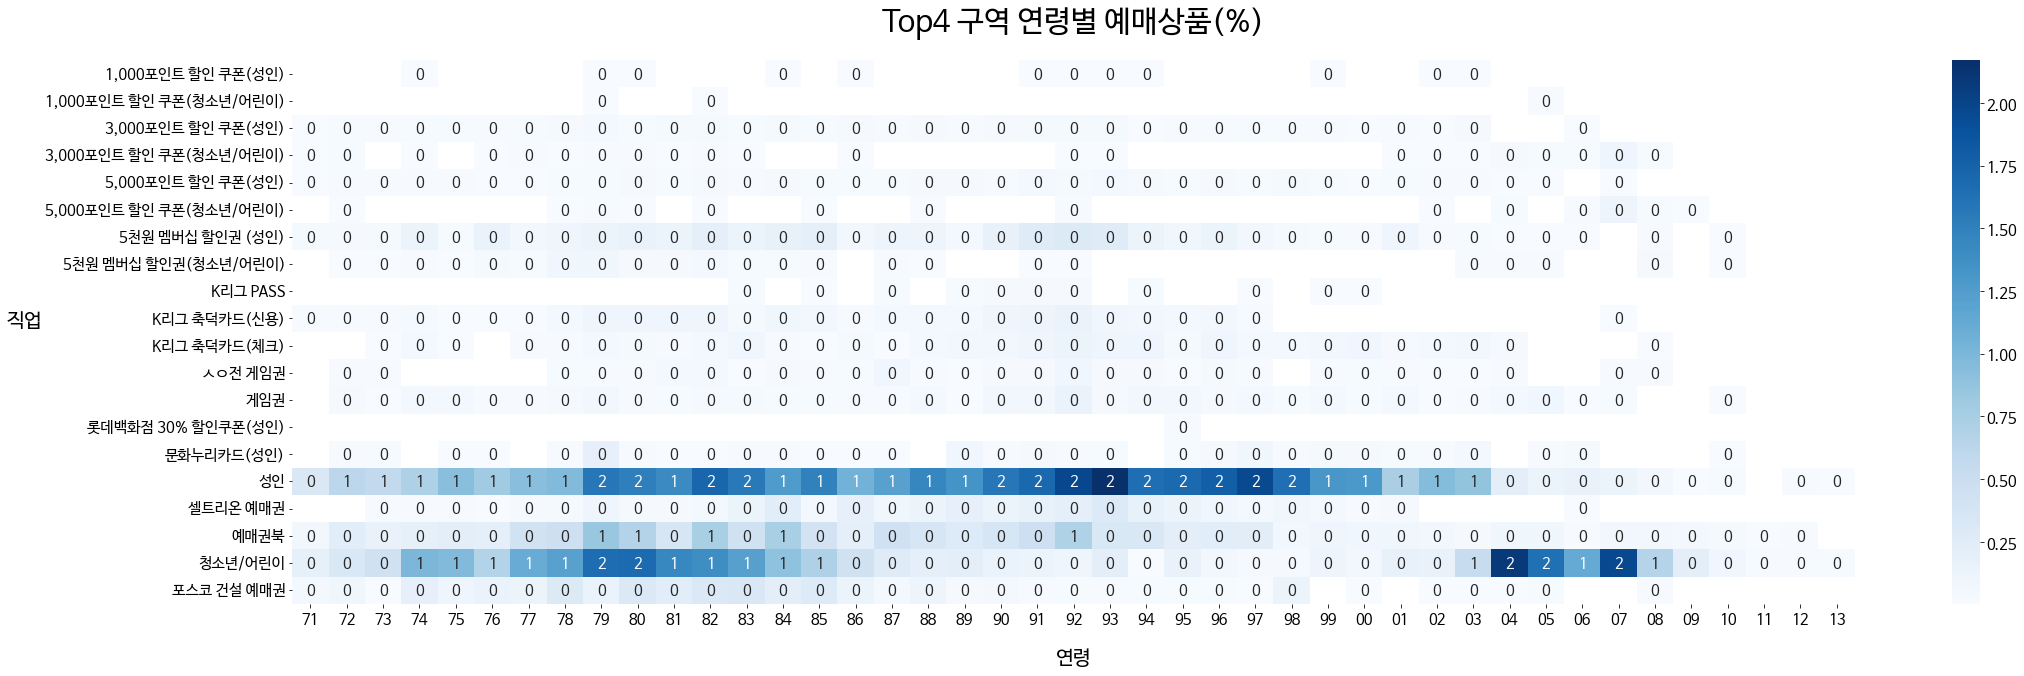

In [67]:
com_70 = com_tk[((com_tk['product_grade_name']== 'Exciting석')|\
       (com_tk['product_grade_name']== 'World class석')|\
       (com_tk['product_grade_name']== 'S석')|\
       (com_tk['product_grade_name']== 'With석'))&\
       (com_tk['MB_AGE'] >1970)]

com_denomi = com_70.pivot_table(index='product_denomination_name',columns='MB_AGE',values='reserve_detail_no',aggfunc=['count'])
com_denomi = com_denomi.droplevel(axis=1,level=0)
com_denomi.rename(columns = lambda x: str(x)[2:4], inplace = True)

# 관객수 비율로 조정
com_denomi_user = com_denomi.sum().sum()
com_denomi = (com_denomi/com_denomi_user)*100

plt.figure(figsize=(35,10))
plt.title('Top4 구역 연령별 예매상품(%)', pad=30, fontsize=30)
sns.heatmap(com_denomi, annot=True, fmt='.0f',cmap='Blues')
plt.xlabel('연령',fontsize=20, labelpad =20)
plt.ylabel('직업', fontsize=20, labelpad =20, rotation='horizontal')
plt.show()

**청소년/어린이상품 예매내역**
- 청소년/어린이 관람객의 비율이 약 24%로 세분화 하여 관리할 필요가 있음
- 직업이나 나이만으로 청소년/어린이를 구분할 수 없음 = > 청소년/어린이상품 예매 내역으로 확인
- 쿠폰 사용비율이 낮은 점을 파악하였음 => 청소년/어린이를 위한 쿠폰의 필요성 인식

In [68]:
# 전체 관람객 중 미성년자 관람객의 비율
com_kids = df2[(df2.product_denomination_name.str.contains('청소년/어린이'))&(df2['MB_AGE']>1970)]
print(f'미성년자 관람객의 비율 : {round(len(com_kids)/len(df2)*100,2)}%')

미성년자 관람객의 비율 : 23.96%


In [440]:
# 청소년/어린이 상품 예매 내역
# 90%이상이 할인혜택 없이 예매
com_kids_rate = com_kids.groupby(['product_denomination_name'],as_index=False)['reserve_no'].count()
cupon_rate = round(com_kids_rate['reserve_no'] / com_kids_rate['reserve_no'].sum() *100,2).astype(str)
com_kids_rate['reserve_no'] = cupon_rate+'%'
com_kids_rate.rename(columns = {'reserve_no':'rate'},inplace=True)
com_kids_rate.sort_values(by='rate', ascending=False, inplace=True)
com_kids_rate

,product_denomination_name,rate
8,청소년/어린이,93.38%
7,성인/청소년/어린이,2.6%
5,5천원 멤버십 할인권(청소년/어린이),2.04%
3,"3,000포인트 할인 쿠폰(청소년/어린이)",1.15%
4,"5,000포인트 할인 쿠폰(청소년/어린이)",0.71%
0,"1,000포인트 할인 쿠폰(청소년/어린이)",0.09%
2,1만원 멤버십 할인권 (청소년/어린이),0.02%
1,10% 할인 쿠폰(청소년/어린이),0.01%
6,생일쿠폰(청소년/어린이),0.01%


**직업을 기타 또는 미입력한 고객의 비중이 크다. 직업을 필수 입력 할 수 있도록 설계하는 것이 분류에 도움이 될 것이다.**
- 고객이 기타를 선택하지 않도록 직업카테고리 세분화
- 기타 또는 입력하지 않은 고객이 직업을 입력 할 경우 할인쿠폰 증정
- 직업이 학생(초/중/고)인데 성인 일반인 결제를 한 경우가 많음 => 고객의 나이에 따라 최신화 필요

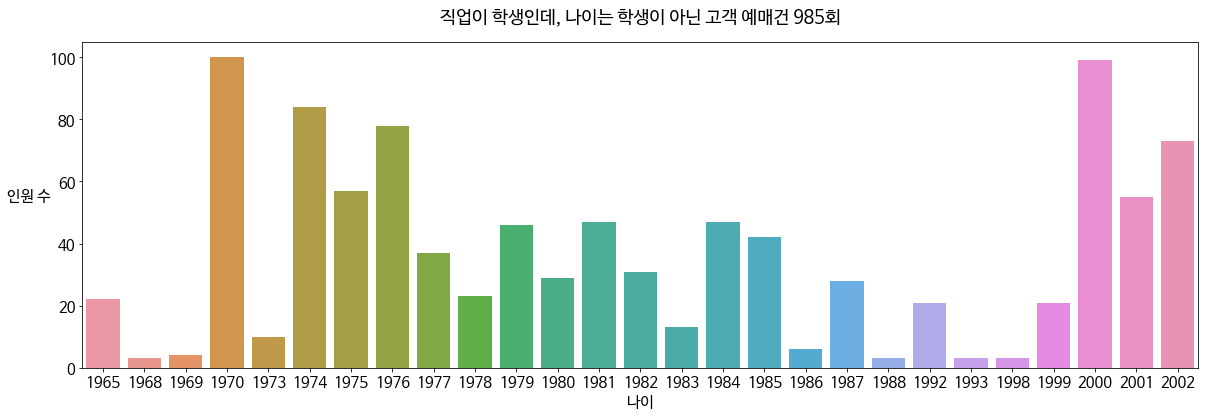

In [70]:
plt.figure(figsize=(20,6))
no_student = df2[(df2['job']=='학생(초/중/고)')&(df2['MB_AGE'] <2003)].groupby('MB_AGE').sum()[['reserve_detail_no']]
sns.barplot(data =no_student, x=no_student.index, y= no_student['reserve_detail_no'])
plt.xlabel('나이')
plt.ylabel('인원 수', rotation='horizontal',labelpad=20)
plt.title(f'직업이 학생인데, 나이는 학생이 아닌 고객 예매건 {no_student.sum()[0]}회',pad = 20)
plt.show()

### 홈경기와 원정경기 비교

- 인천utd 경기장은 홈팬의 이용률이 더 높은 경기장
- 홈팬을 위한 다양한 혜택도 필요하나, '차비 값을 드립니다'같은 문구로 원정팬의 할인행사를 진행하는 것도 좋을 것 같다.

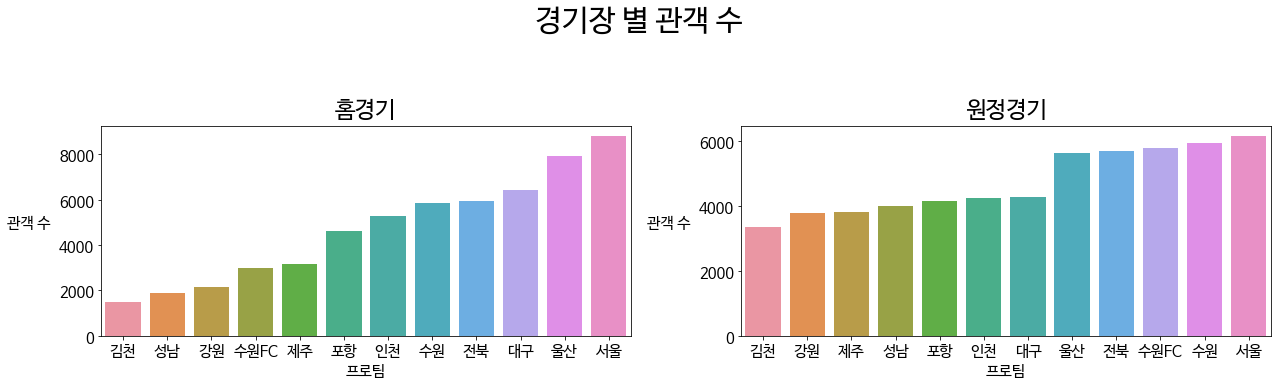

In [71]:
# 전체적으로 홈경기장에서 경기할 때가 원정경기 할 때보다 관객 수가 많다.

field_audi_h = df4.groupby('home_team_name',as_index=False)[['home_team_name','audience']].mean().sort_values(by='audience')
field_audi_a = df4.groupby('away_team_name',as_index=False)[['away_team_name','audience']].mean().sort_values(by='audience')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,5))
sns.barplot(data = field_audi_h, x='home_team_name', y= 'audience', ax=ax[0])
sns.barplot(data = field_audi_a, x='away_team_name', y= 'audience', ax=ax[1])

ax[0].set_title("홈경기", fontsize=23, pad = 10)      # 각 그래프 타이틀
ax[1].set_title("원정경기", fontsize=23, pad= 10)

ax[0].set_xlabel('프로팀',fontsize=15)
ax[0].set_ylabel('관객 수',fontsize=15, rotation='horizontal', labelpad=30)
ax[1].set_xlabel('프로팀',fontsize=15)
ax[1].set_ylabel('관객 수',fontsize=15, rotation='horizontal', labelpad=30)
fig.suptitle('경기장 별 관객 수', y=1.08, fontsize=30)

fig.tight_layout() 
plt.show();

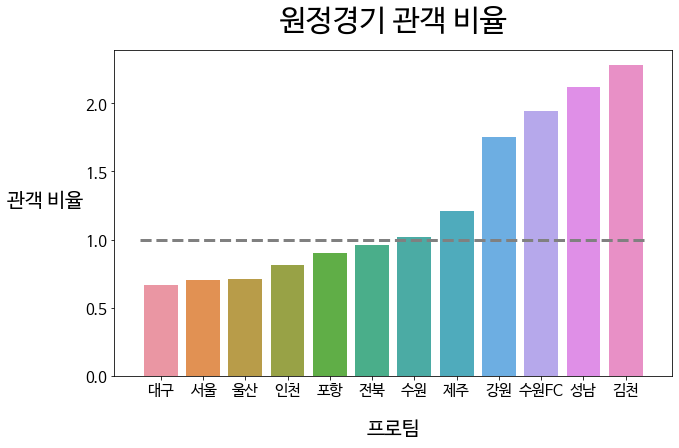

In [72]:
field_audi_all = field_audi_h.copy()
field_audi_all['audience'] = round(field_audi_a['audience']/ field_audi_h['audience'],2).sort_values()
field_audi_all.rename(columns={'audience':'away_percent'},inplace=True)
field_audi_all.sort_values(by='away_percent',inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(data= field_audi_all, x= 'home_team_name', y='away_percent')
plt.title('원정경기 관객 비율',pad=20, fontsize=30)
plt.xlabel('프로팀',fontsize=20, labelpad =20)
plt.ylabel('관객 비율', fontsize=20, labelpad =40, rotation='horizontal')
plt.hlines(1, -0.5, 11.5, color='gray', linestyle='--', linewidth=3)
plt.show();

### 관객들의 경기 예매 시간은 언제일까?

- 주로 월, 화, 수 14시경 예매를 많이 함
   - 마케팅 효과를 극대화할 수 있는 시간
- 경기 3일 후와 당일 예매를 많이함
   - 3일 후 예매하는 이유는 찾지 못함
- 당일 예매자 리텐션 코흐트분석 결과 당일 예매자들은 꾸준히 당일예매를 이용
   - 온라인 예매를 이용할 수 있도록 유도하여 관객 수를 예측 가능하도록 만들어야함

In [73]:
use_time_com = df2.copy()

# 사용 시간만 빼서 time컬럼 생성
use_time_com['time'] = use_time_com['reserve_time'].dt.hour
use_time_com['reserve_yoil'] = use_time_com['reserve_time'].dt.weekday

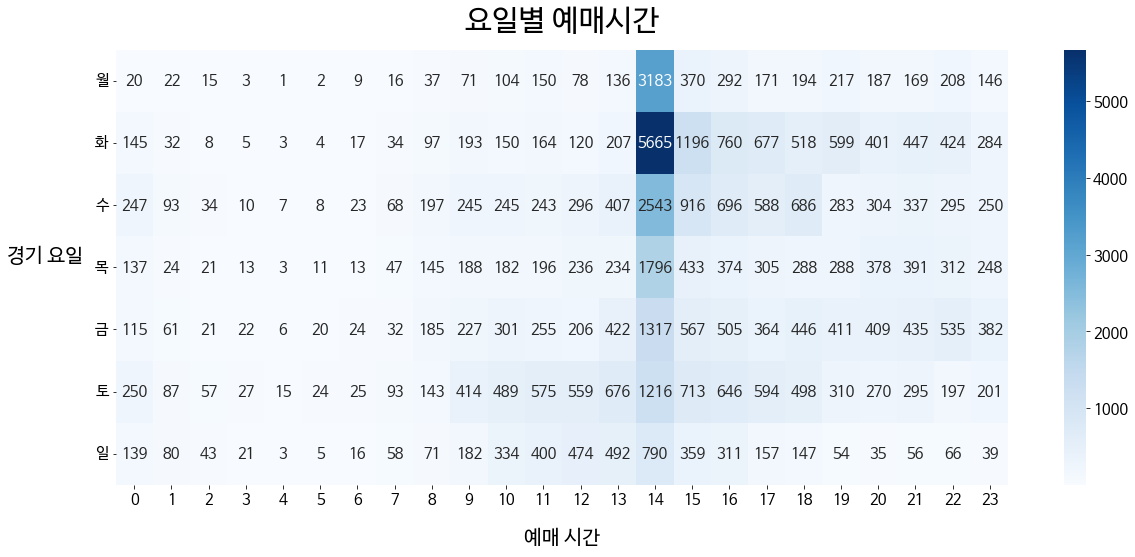

In [74]:
# 요일별 예매시간
# 주로 월, 화, 수 14시에 많이 예매
plt.figure(figsize=(20,8))
mk_heat(use_time_com,'time', 'reserve_yoil')
plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5], ['월','화','수','목','금','토','일'],rotation='horizontal')
plt.title('요일별 예매시간', pad=20, fontsize=30)
plt.ylabel('경기 요일', labelpad=50,rotation='horizontal',fontsize=20)
plt.xlabel('예매 시간',labelpad=20, fontsize=20)
plt.show();

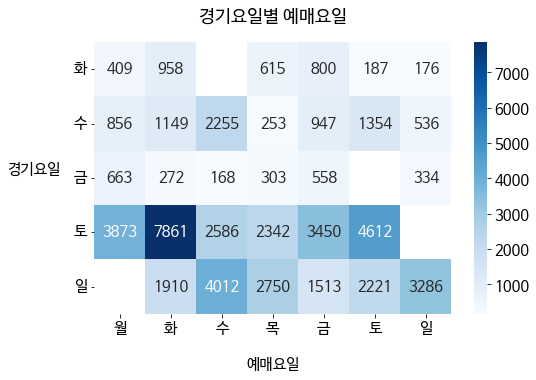

In [75]:
# 경기 요일별로 티켓을 구매하는 요일
# 경기 후 3일 뒤, 경기당일 많이 구매

plt.figure(figsize=(8,5))
mk_heat(use_time_com, 'reserve_yoil', 'game_yoil')
plt.title('경기요일별 예매요일',pad=20)
plt.ylabel('경기요일', labelpad=40,rotation='horizontal')
plt.xlabel('예매요일',labelpad=20)
plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5], ['월','화','수','목','금','토','일'])
plt.yticks([0.5,1.5,2.5,3.5,4.5], ['화','수','금','토','일'],rotation='horizontal')
plt.show();
plt.show();

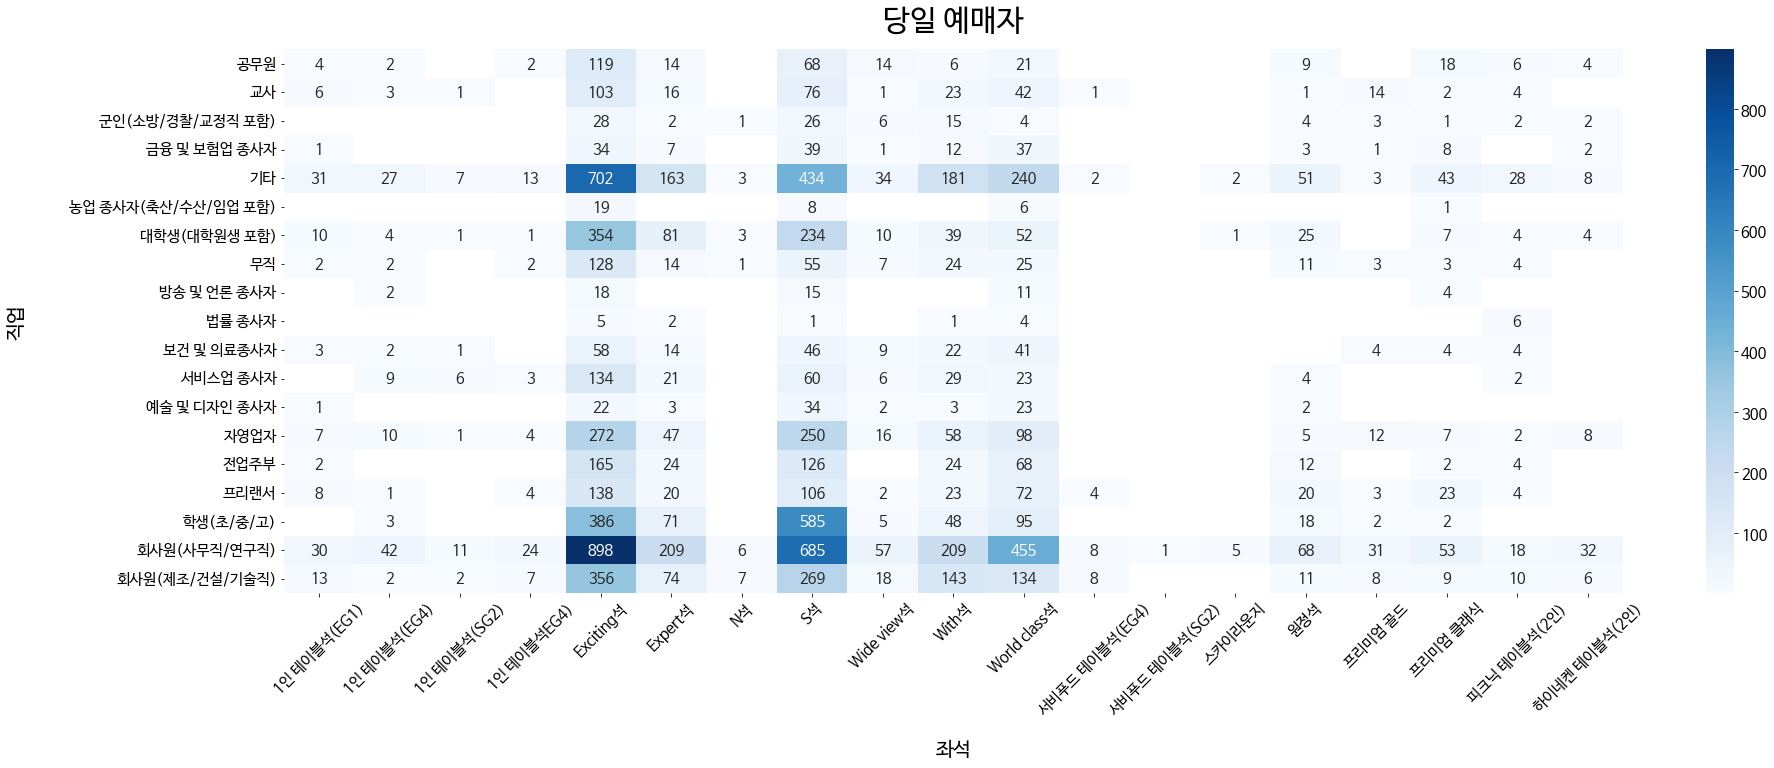

In [76]:
# 당일 예매자의 특징 찾아보기
# 별다른 정보는 찾지못함
day_reserve = use_time_com[use_time_com.game_now.dt.date == use_time_com.reserve_time.dt.date]

plt.figure(figsize=(30,10))
plt.title('당일 예매자',pad=20,fontsize=30)
mk_heat(day_reserve, 'product_grade_name','job')
plt.xticks(rotation=45)
plt.ylabel('직업', labelpad=40,fontsize=20)
plt.xlabel('좌석',labelpad=20,fontsize=20)
plt.show()

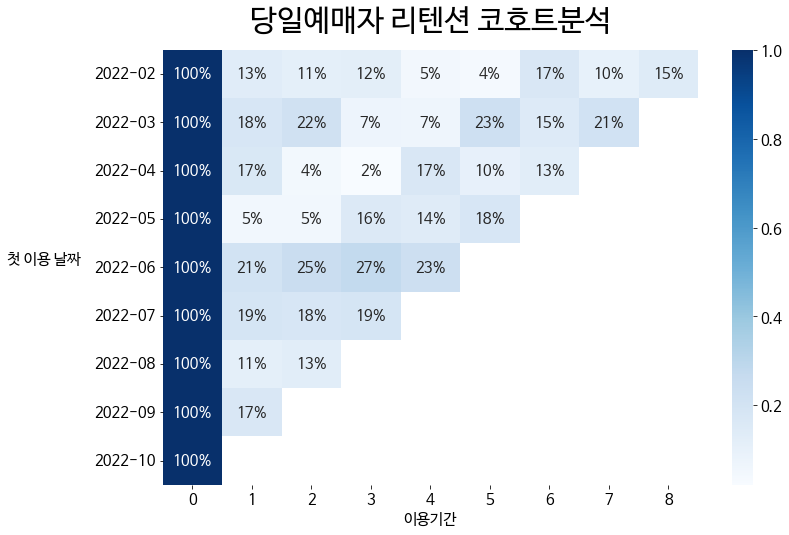

In [77]:
# 당일 예매자 코호트 분석
mk_cohort(day_reserve, '당일예매자 리텐션 코호트분석')

### 월별 경기 수에 따른 관객 수

- 월에 경기가 많을수록 그 달의 평균 관객 수가 늘어난다.

In [403]:
# 월별 경기 횟수
in_mon_num = in_df.groupby('month',as_index=False)[['audience']].count()
in_mon_num.rename(columns={'audience':'count'},inplace=True)

# 월별 관객 수
in_mon_sum = in_df.groupby('month',as_index=False)[['audience']].sum()
in_mon_sum.rename(columns={'audience':'sum'},inplace=True)

# 월별 평균관객 수
in_mon_mean = in_df.groupby('month',as_index=False)[['audience']].mean().round()
in_mon_mean.rename(columns={'audience':'mean'},inplace=True)

# 경기 횟수 별 관중 수 비교표
in_total = pd.merge(in_mon_num,in_mon_sum, how='inner',on='month')
in_total = pd.merge(in_total,in_mon_mean, how='inner',on='month')
in_total.rename(columns = {'sum':'total_audi','mean':'mean_audi'},inplace=True)
in_total['count'] = in_total['count'].astype('str') + '회'
in_total['mean_audi'] = in_total['mean_audi'].astype('int')
in_total

,month,count,total_audi,mean_audi
0,02,2회,10000,5000
1,03,2회,6188,3094
2,04,2회,12288,6144
3,05,3회,16470,5490
4,06,1회,2509,2509
5,07,1회,3647,3647
6,08,3회,20209,6736
7,09,2회,8844,4422
8,10,3회,19813,6604


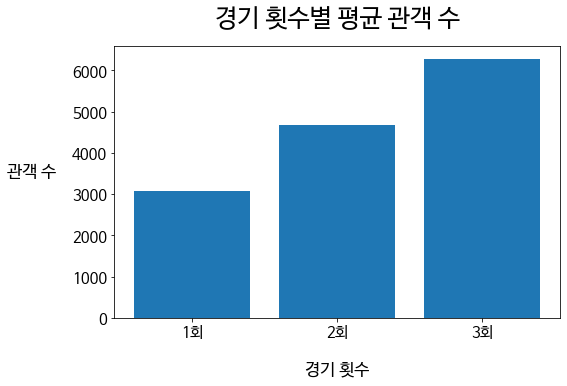

In [404]:
# 경기 횟수 별 평균 관중 수
# 월별 경기 횟수가 많아질수록 관객의 수가 증가한다.

in_total_count = in_total.groupby('count',as_index=False)[['mean_audi']].mean()

plt.figure(figsize=(8,5))
plt.bar(in_total_count['count'],in_total_count['mean_audi'])
plt.title('경기 횟수별 평균 관객 수',pad=20, fontsize=25)
plt.ylabel('관객 수', rotation='horizontal', labelpad=40, fontsize=17)
plt.xlabel('경기 횟수', rotation='horizontal', labelpad=20, fontsize=17)
plt.show();

### 할인권 사용자 분석

In [83]:
# 원정석을 제외한 티켓 종류
df2[df2.product_grade_name!='원정석']['product_denomination_name'].unique()

array(['5천원 멤버십 할인권 (일반)', '예매권북', '성인', '5,000포인트 할인 쿠폰(성인)', '게임권',
       'K리그 축덕카드(신용)', '3,000포인트 할인 쿠폰(성인)', '5천원 멤버십 할인권 (성인)',
       '1인 테이블석 할인권', '청소년/어린이', '5,000포인트 할인 쿠폰(일반)', '일반',
       '3,000포인트 할인 쿠폰(일반)', '1,000포인트 할인 쿠폰(성인)', 'ㅅㅇ전 게임권',
       'N회 방문자 할인쿠폰', 'K리그 축덕카드(체크)', '셀트리온 예매권', '1인 테이블석 50% 할인쿠폰',
       '5,000포인트 할인 쿠폰(청소년/어린이)', '문화누리카드(성인)', '포스코 건설 예매권',
       '5천원 멤버십 할인권(청소년/어린이)', '3,000포인트 할인 쿠폰(청소년/어린이)',
       '1,000포인트 할인 쿠폰(청소년/어린이)', '프리미엄 골드석 50% 할인쿠폰', '10% 할인 쿠폰(성인)',
       '10% 할인 쿠폰(청소년/어린이)', '생일쿠폰(성인)', '1만원 멤버십 할인권 (성인)',
       '생일쿠폰(청소년/어린이)', '1만원 멤버십 할인권 (청소년/어린이)', 'K리그 PASS',
       '1,000포인트 할인 쿠폰(일반)', '롯데백화점 30% 할인쿠폰(성인)'], dtype=object)

In [84]:
# 할인권사용자
com_discount = df2[(df2.product_denomination_name!='성인/청소년/어린이') &\
                   (df2.product_denomination_name!='청소년/어린이') &\
                   (df2.product_denomination_name!='성인') &\
                   (df2.product_denomination_name!='청소년') &\
                   (df2.product_denomination_name!='어린이') &\
                   (df2.product_denomination_name!='일반') &\
                   (df2.reserve_state_code =='COMPLETE')&\
                   (df2.cancel_yn == 'N')]

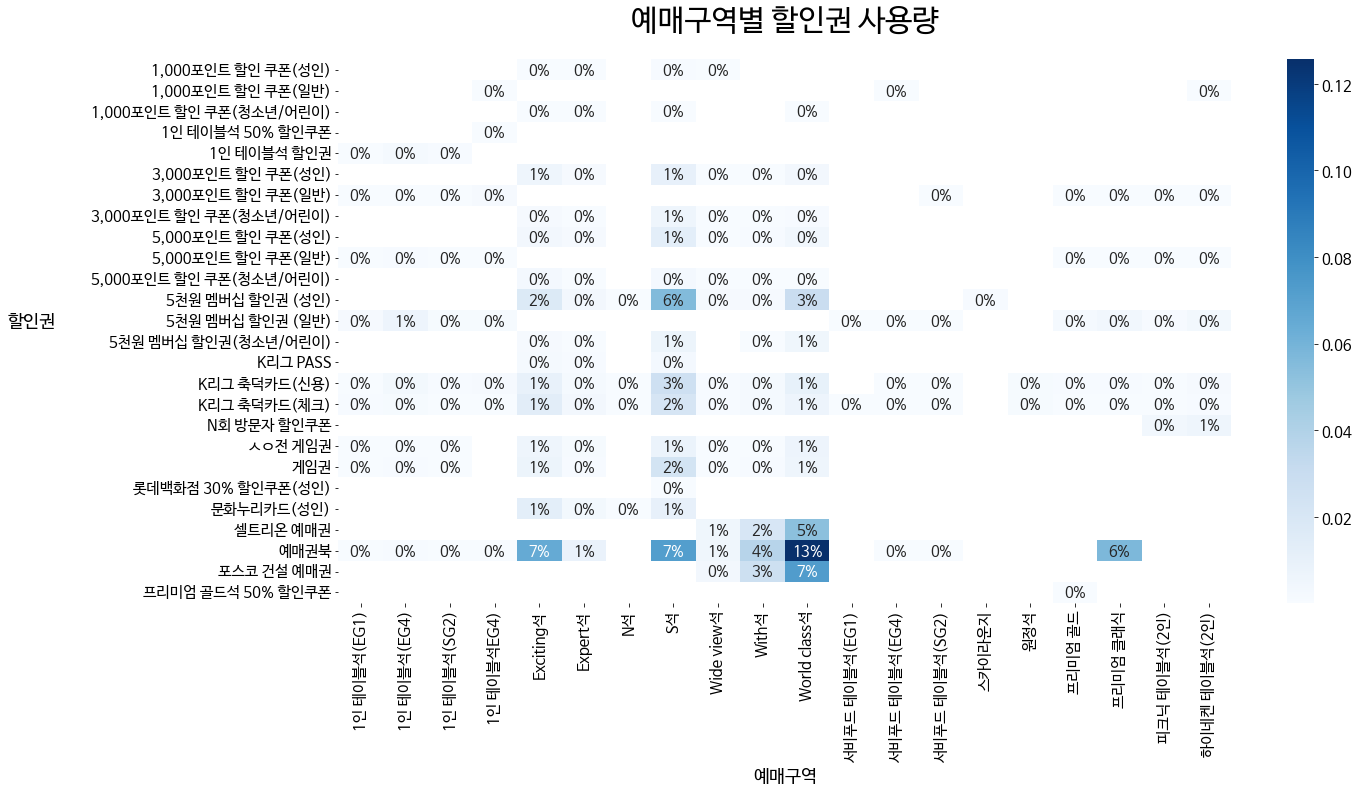

In [85]:
# 할인 사용자들(com_discount)이 할인권을 어느 좌석에 많이 쓰는지
discount_pivot = com_discount.pivot_table(index ='product_denomination_name', columns='product_grade_name', values='reserve_no',aggfunc='count')
sum_discount = discount_pivot.sum().sum()
discount_pivot = (discount_pivot/sum_discount)

plt.figure(figsize=(20,10))
plt.title('예매구역별 할인권 사용량', pad=30, fontsize=30)
sns.heatmap(discount_pivot, annot=True, fmt='.0%', cmap='Blues')
plt.xlabel('예매구역',fontsize=18)
plt.ylabel('할인권', labelpad=60, rotation='horizontal',fontsize=18)
plt.show();

**예매권북이 가장 많이 사용된 할인권**

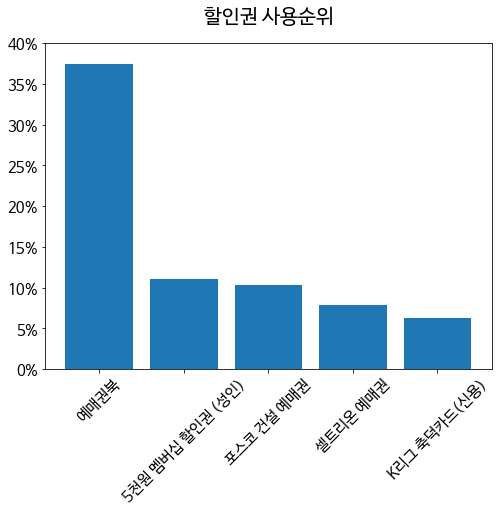

In [86]:
# 가장 많이 사용된 쿠폰 5개
most_discount = com_discount.groupby('product_denomination_name',as_index=False)['reserve_no'].count().sort_values(by = 'reserve_no',ascending=False)
most_discount.rename(columns={'reserve_no':'count'},inplace=True)

sum_most_dis = most_discount['count'].sum()
most_discount['count'] = (most_discount['count'] / sum_most_dis) * 100
most_discount = most_discount[:5]


plt.figure(figsize=(8,6))
plt.title('할인권 사용순위', pad=20, fontsize=20)
plt.bar(most_discount.product_denomination_name, most_discount['count'])
plt.xticks(rotation=45)
plt.yticks(np.arange(0,41,5),['0%','5%','10%','15%','20%','25%','30%','35%','40%'])
plt.show();

**할인권이 가장 많이 사용된 좌석 : World Class**

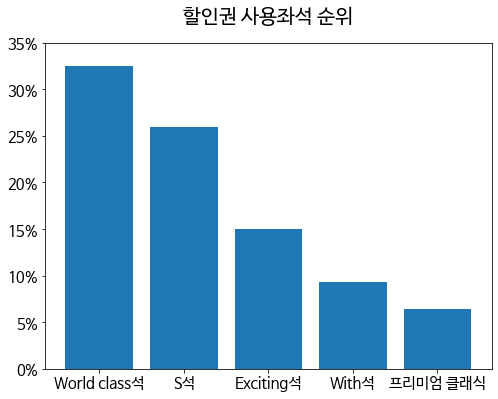

In [87]:
# 할인쿠폰이 가장 많이 사용된 좌석
discount_book = com_discount.groupby(['product_grade_name'],as_index=False)['reserve_no'].count().sort_values(by = 'reserve_no',ascending=False)
discount_book.rename(columns={'reserve_no':'count'},inplace=True)

sum_dis_book = discount_book['count'].sum()
discount_book['count'] = (discount_book['count']/sum_dis_book)*100
discount_book = discount_book[:5]

plt.figure(figsize=(8,6))    
plt.title('할인권 사용좌석 순위', pad=20, fontsize=20)     
plt.bar(discount_book['product_grade_name'], discount_book['count'])
plt.yticks(np.arange(0,36,5),['0%','5%','10%','15%','20%','25%','30%','35%'])
plt.show();

**수익성이 좋은 프리미엄 클래식구역은 예매권북 예매가 전체의 71%**

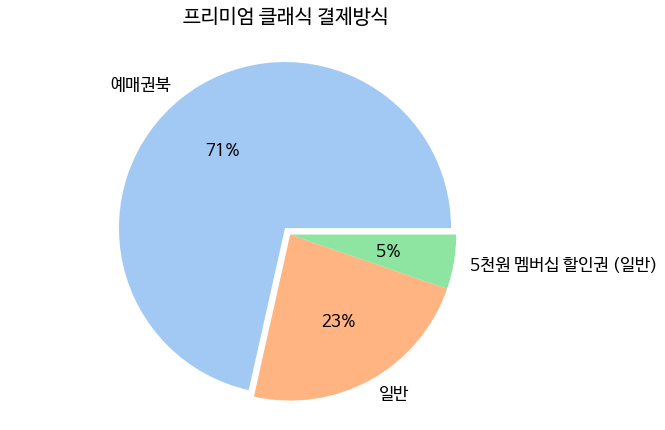

In [88]:
# 프리미엄클래식의 예매 내역
premium_tk = com_tk[(com_tk['product_grade_name']=='프리미엄 클래식')]

premium_tk_mon = premium_tk.groupby('product_denomination_name',as_index=False)['reserve_no'].count().sort_values(by = 'reserve_no',ascending=False)[:3]
premium_tk_mon.rename(columns={'reserve_no':'count'},inplace=True)

plt.figure(figsize=(10,7))
plt.title('프리미엄 클래식 결제방식', pad=20, fontsize=20)
# plt.bar(premium_tk_mon.product_denomination_name, premium_tk_mon['count'])
plt.pie(x = premium_tk_mon['count'], labels=premium_tk_mon['product_denomination_name'],colors=sns.color_palette('pastel'), autopct='%.0f%%',\
         textprops={'size':17}, explode=(0.05, 0, 0))
plt.axis('equal')
plt.xticks(rotation=45)
plt.show();

**프리미엄 클래식구역은 시즌 후반에 많이 사용되는 경향이 있다.**

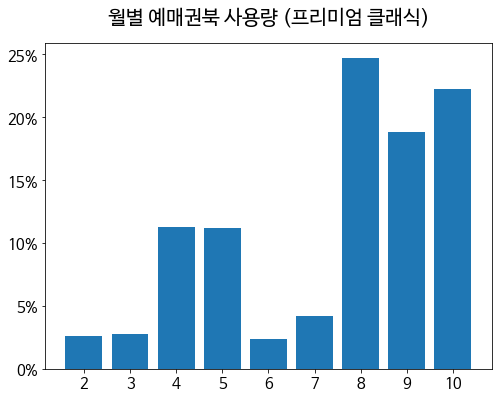

In [452]:
# 프리미엄클래식구역의 월별 예매권북 사용자 수
# 시즌 후반에 사용량이 많은 편이다.
# 시즌 초중반에 할인행사를 진행하여 예매권북 사용자들의 고급좌석의 수요를 늘린다.
pre_res_tk = com_discount[(com_discount['product_grade_name']=='프리미엄 클래식')& (com_discount['product_denomination_name']=='예매권북')]
pre_res_mon = pre_res_tk.groupby('game_month',as_index=False)['game_date'].nunique()
pre_res = pre_res_tk.groupby('game_month',as_index=False)['reserve_no'].count()

pre_res = pd.merge(pre_res, pre_res_mon, on='game_month')
pre_res['mean'] = pre_res['reserve_no']/pre_res['game_date']

pre_res['reserve_no'] = pre_res['reserve_no']/pre_res['reserve_no'].sum().sum()*100

plt.figure(figsize=(8,6))    
plt.title('월별 예매권북 사용량 (프리미엄 클래식)', pad=20, fontsize=20)     
plt.bar(pre_res['game_month'], pre_res['reserve_no'])
plt.xticks(range(2,11))
plt.yticks(np.arange(0,26,5),['0%','5%','10%','15%','20%','25%'])
plt.show();

In [454]:
# 월별 프리미엄클래식, 일반구역 평균이용 표
in_field['game_month'] = in_field['game_date'].dt.strftime('%m')
pre_audiencein = in_field.groupby('game_month')[['audience']].sum()
pre_audiencein.index = pre_audiencein.index.astype(int)

tk_month = com_tk[com_tk['product_grade_name']=='프리미엄 클래식'].groupby('game_month')[['reserve_no']].count()
tk_month.rename(columns={'reserve_no':'pre_audi'}, inplace=True)
tk_month['num'] = premium_tk.groupby('game_month').nunique()['game_date']
tk_month['mean_audi'] = round(tk_month.pre_audi/tk_month.num)
tk_month['all_mean_audi'] = round(pre_audiencein['audience']/tk_month['num'])
tk_month

,pre_audi,num,mean_audi,all_mean_audi
game_month,,,,
2,50,2,25.0,5000.0
3,47,2,24.0,3094.0
4,141,2,70.0,6144.0
5,169,3,56.0,5490.0
6,25,1,25.0,2509.0
7,45,1,45.0,3647.0
8,230,3,77.0,6736.0
9,181,2,90.0,4422.0
10,222,3,74.0,6604.0


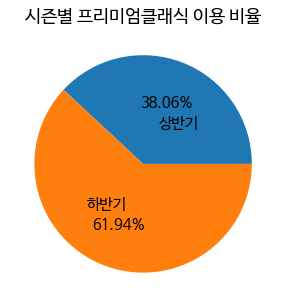

In [91]:
# 프리미엄 클래식구역 이용률 상하반기 비율
# 프리미엄 클래식은 예매권북 사용이 주를 이루므로 상반기에 프리미엄클래식 할인행사를 진행하여 예매권북 소지자들의 구매유도
pie_pre = pd.DataFrame({"audience" : (tk_month.pre_audi[:5].sum(), tk_month.pre_audi[-5:].sum()),
                        "season" : ('상반기','하반기')})
plt.figure(figsize=(8,5))
plt.title('시즌별 프리미엄클래식 이용 비율')
plt.pie(x=pie_pre['audience'],labels=pie_pre['season'], autopct='%.2f%%', labeldistance=0.4)
plt.axis
plt.show();

**할인권 호응이 좋은 연령**
- 할인권 사용자의 71%가 75년~95년생
- 할인권 사용자의 리텐션 코호트분석 결과 마찬가지로 시즌 초반에 할인권을 구매한 고객들이 리텐션이 높았다.

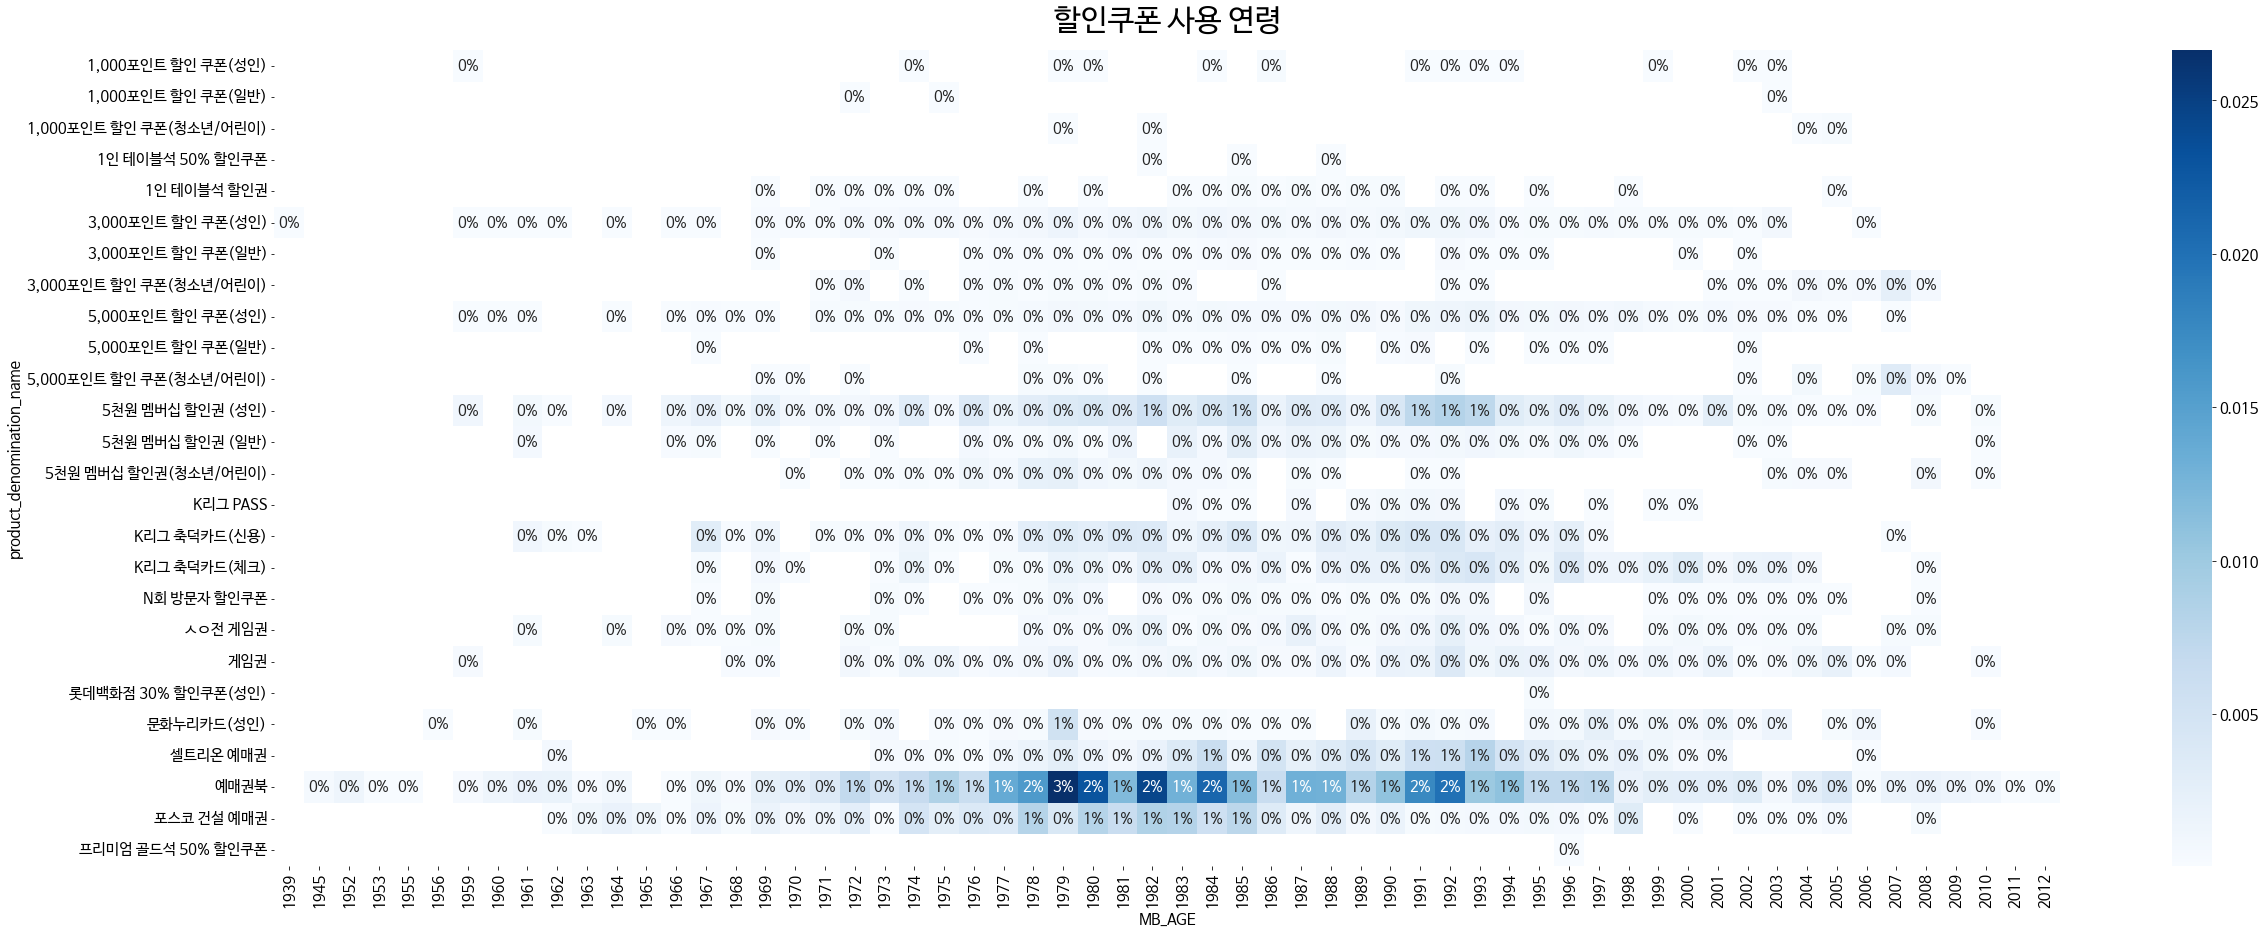

In [413]:
# 쿠폰을 많이 사용하는 연령
# 75~95년생들에서 두드러진다.
cupon_pivot = com_discount.pivot_table(index='product_denomination_name', columns = 'MB_AGE', values='reserve_no',aggfunc='count')
sum_cupon = cupon_pivot.sum().sum()
cupon_pivot = cupon_pivot/sum_cupon

plt.figure(figsize=(40,15))
plt.title('할인쿠폰 사용 연령', pad=20, fontsize=30)
sns.heatmap(cupon_pivot, annot=True, fmt='.0%',cmap='Blues')
plt.show();

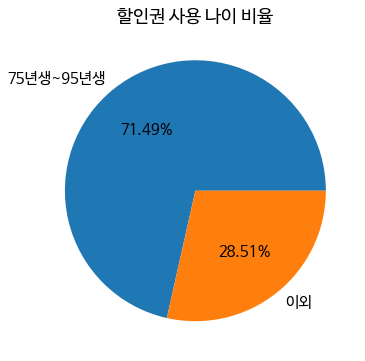

In [94]:
# 할인권을 사용하는 나이를 비율로 나타내보았다.
discount_7595 = com_discount[(com_discount['MB_AGE'] >1975)&(com_discount['MB_AGE'] <1995)]

dis_pie = pd.DataFrame({ 'age' :( '75년생~95년생', '이외'),
                        'audience' : (len(discount_7595),len(com_discount)-len(discount_7595))})

plt.figure(figsize=(8,6))
plt.title('할인권 사용 나이 비율')
plt.pie(x=dis_pie.audience, labels=dis_pie.age, autopct='%1.2f%%')
plt.axis
plt.show();

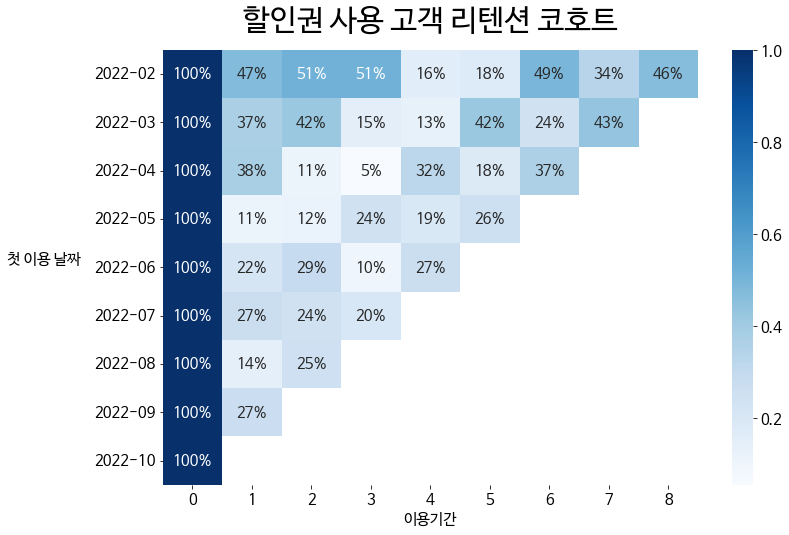

In [95]:
# 할인권 이용자들의 리텐션
# 초반에 할인권을 가질수록 리텐션이 높게 유지된다.(예매권북의 영향?)
mk_cohort(com_discount,'할인권 사용 고객 리텐션 코호트')

### 고급좌석 이용자 분석

- 고급좌석은 75~95년생 자녀가 없는 직장인들이 주로 이용하는 것으로 확인

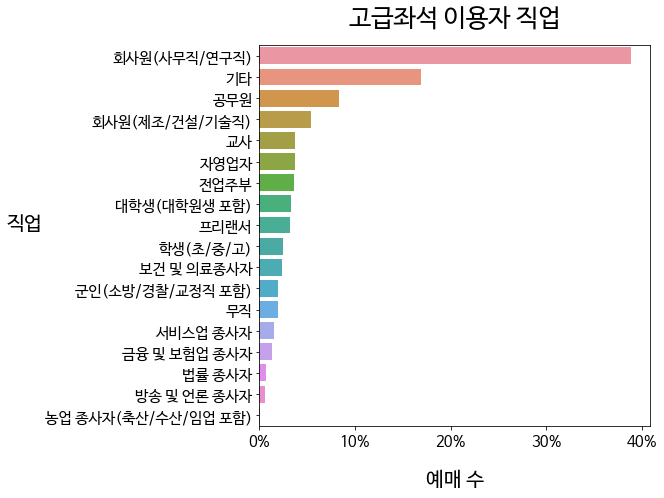

In [96]:
# 고급좌석 이용자 직업은 직장인인
com_exp = com_tk[(com_tk['product_grade_name']== '스카이라운지')|\
       (com_tk['product_grade_name']== '프리미엄 클래식')|\
       (com_tk['product_grade_name']== '프리미엄 골드')]
com_job_exp = com_exp.groupby('job').count()[['reserve_no']].sort_values(by='reserve_no',ascending=False)
sum_exp = com_job_exp['reserve_no'].sum()
com_job_exp['reserve_no'] = (com_job_exp['reserve_no']/sum_exp)*100

plt.figure(figsize=(7,7))
plt.title('고급좌석 이용자 직업', pad=20, fontsize=25)
sns.barplot(data = com_job_exp, x='reserve_no', y =com_job_exp.index, )
plt.xlabel('예매 수',fontsize=20, labelpad =20)
plt.ylabel('직업', fontsize=20, labelpad =20, rotation='horizontal')
plt.xticks(np.arange(0,41,10),['0%', '10%','20%','30%','40%'])
plt.show();

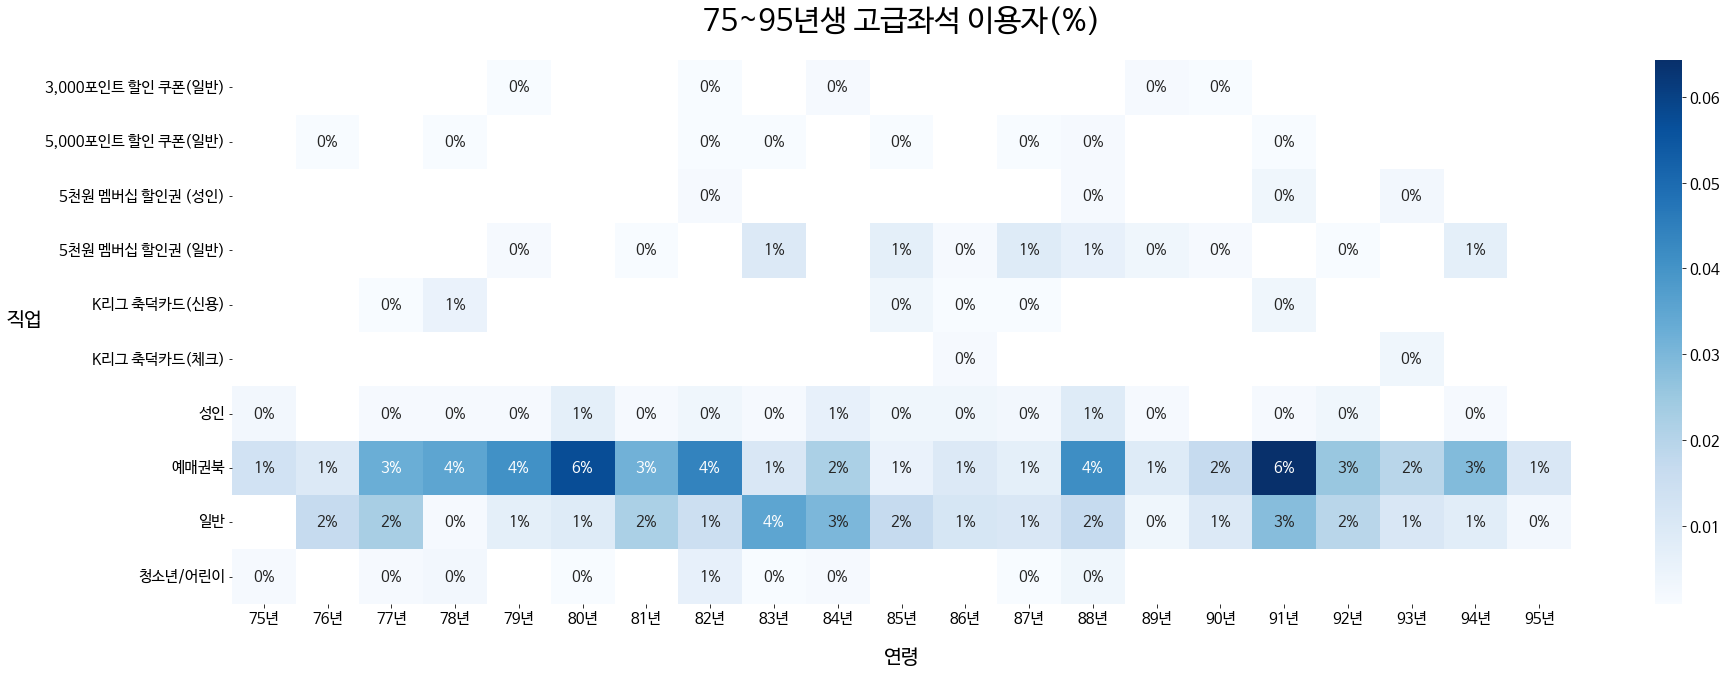

In [402]:
# 대다수가 75년생~95년생
com_age_job_exp = com_tk[(com_tk['MB_AGE']>1974)&(com_tk['MB_AGE']<1996)&\
                     ((com_tk['product_grade_name']== '스카이라운지')|(com_tk['product_grade_name']== '프리미엄 골드')| (com_tk['product_grade_name']== '프리미엄 클래식'))]

age_job_pivot = com_age_job_exp.pivot_table(index='product_denomination_name',columns='MB_AGE',values='reserve_detail_no',aggfunc=['count'])
age_job_pivot = age_job_pivot.droplevel(axis=1,level=0)
age_job_pivot.rename(columns = lambda x: str(x)[2:4]+'년', inplace = True)
age_job_pivot = (age_job_pivot/age_job_pivot.sum().sum())

plt.figure(figsize=(30,10))
plt.title('75~95년생 고급좌석 이용자(%)', pad=30, fontsize=30)
sns.heatmap(age_job_pivot, annot=True, fmt='.0%',cmap='Blues')
plt.xlabel('연령',fontsize=20, labelpad =20)
plt.ylabel('직업', fontsize=20, labelpad =20, rotation='horizontal')
plt.show()

In [447]:
# 고급좌석(프리미엄클래식, 프리미엄골드, 스카이라운지) 이용자의 구매 상품
# 청소년/어린이 상품 이용 비중이 거의 없음
exp_list = list(com_exp.index)
exp_query = com_tk.query('index in @exp_list')
exp_query = exp_query.groupby(['product_denomination_name'])[['reserve_no']].count().sort_values(by='reserve_no')
exp_query.rename(columns = {'reserve_no':'count'},inplace=True)
exp_query['count'] = round((exp_query['count']/exp_query['count'].sum())*100,1).astype('str') + '%'
exp_query

,count
product_denomination_name,
프리미엄 골드석 50% 할인쿠폰,0.1%
"3,000포인트 할인 쿠폰(일반)",0.6%
"5,000포인트 할인 쿠폰(일반)",0.7%
5천원 멤버십 할인권 (성인),0.7%
K리그 축덕카드(체크),0.7%
K리그 축덕카드(신용),1.8%
청소년/어린이,1.8%
성인,4.6%
5천원 멤버십 할인권 (일반),5.9%


### 테이블석 이용자

- 고급좌석과 마찬가지로 75~95년생 직장인이 주를 이루며 청소년/어린이 구매이력이 없는 고객들이다.
- 테이블석은 예매권북의 판매가 저조한 것을 확인할 수 있다.
- 따라서 추가적인 할인 행사를 진행하면 수요를 더 끌어올릴 수 있을 것으로 보인다.

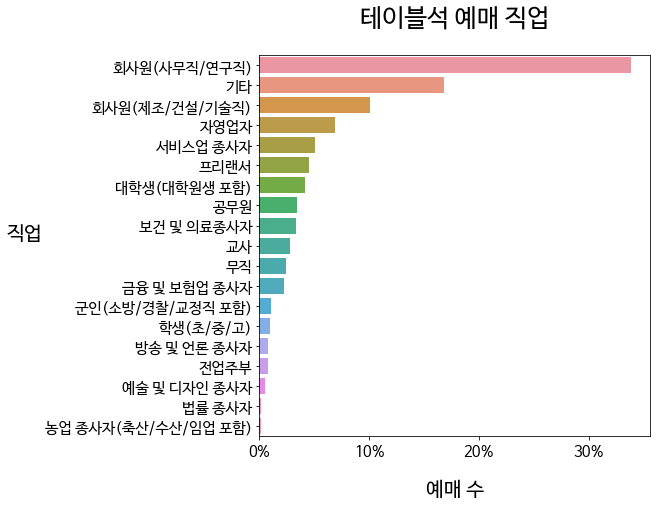

In [99]:
# 테이블석 이용자 직업
# 마찬가지로 회사원이 많음
com_table = com_tk[(com_tk['product_grade_name']== '하이네켄 테이블석(2인)')|\
       (com_tk['product_grade_name']== '피크닉 테이블석(2인)')|\
       (com_tk['product_grade_name']== '1인 테이블석(SG2)')|\
       (com_tk['product_grade_name']== '1인 테이블석(EG4)')|\
       (com_tk['product_grade_name']== '1인 테이블석EG4)')|\
       (com_tk['product_grade_name']== '1인 테이블석(EG1)')|\
       (com_tk['product_grade_name']== '서비푸드 테이블석(EG4)')|\
       (com_tk['product_grade_name']== '서비푸드 테이블석(SG2)')|\
       (com_tk['product_grade_name']== '서비푸드 테이블석(EG1)')]

com_job_table = com_table.groupby('job')[['reserve_no']].count().sort_values(by='reserve_no',ascending=False)
com_job_table['reserve_no'] = (com_job_table['reserve_no']/com_job_table['reserve_no'].sum())*100

plt.figure(figsize=(7,7))
plt.title('테이블석 예매 직업', pad=30, fontsize=25)
sns.barplot(data = com_job_table, x='reserve_no', y =com_job_table.index, )
plt.xlabel('예매 수',fontsize=20, labelpad =20)
plt.ylabel('직업', fontsize=20, labelpad =20, rotation='horizontal')
plt.xticks(np.arange(0,36,10),['0%','10%','20%','30%'])
plt.show();

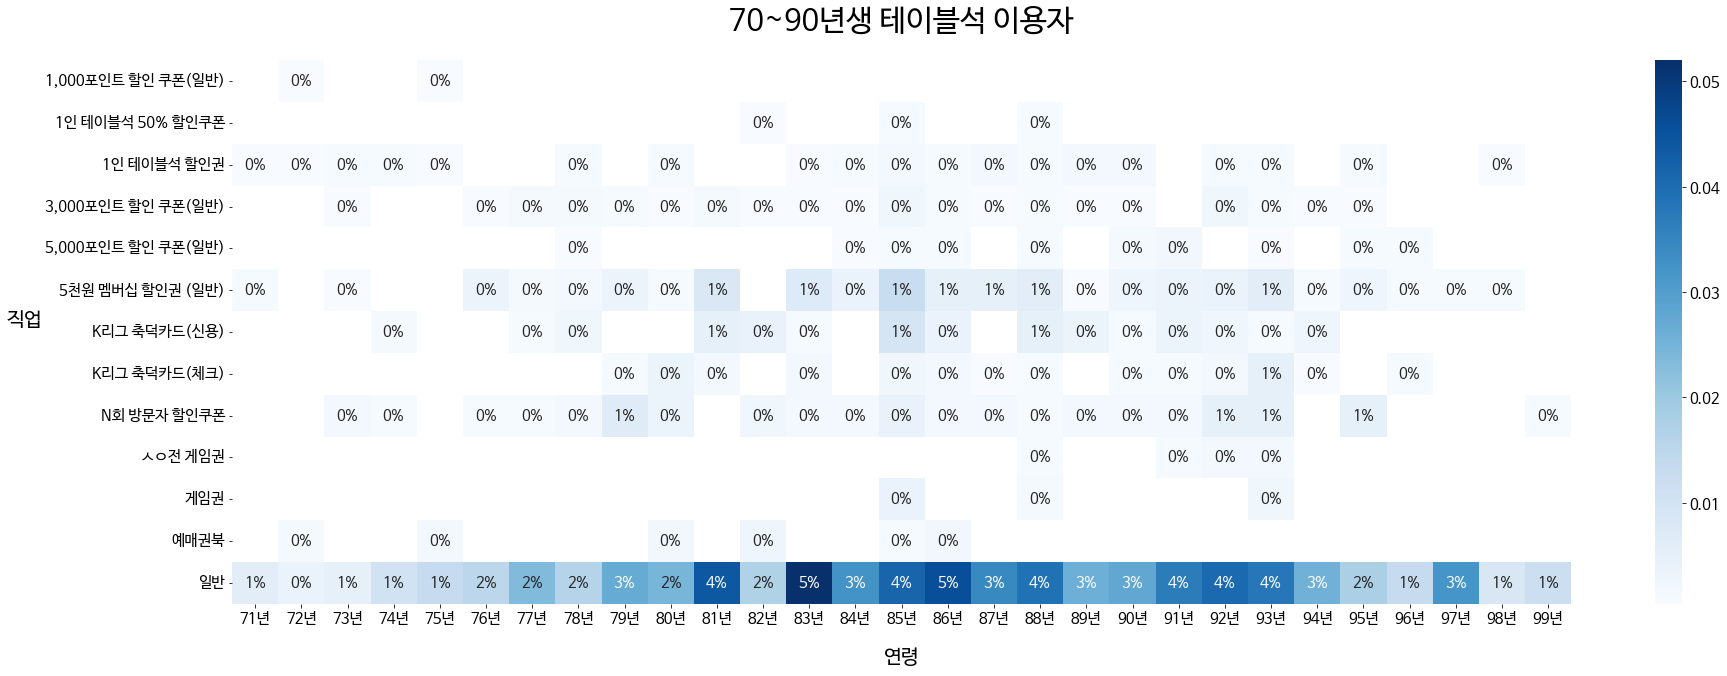

In [100]:
# 테이블석 이용 연령 및 직업
com_age_table = com_tk[((com_tk['product_grade_name']== '하이네켄 테이블석(2인)')|\
       (com_tk['product_grade_name']== '피크닉 테이블석(2인)')|\
       (com_tk['product_grade_name']== '1인 테이블석(SG2)')|\
       (com_tk['product_grade_name']== '1인 테이블석(EG4)')|\
       (com_tk['product_grade_name']== '1인 테이블석EG4)')|\
       (com_tk['product_grade_name']== '1인 테이블석(EG1)')|\
       (com_tk['product_grade_name']== '서비푸드 테이블석(EG4)')|\
       (com_tk['product_grade_name']== '서비푸드 테이블석(SG2)')|\
       (com_tk['product_grade_name']== '서비푸드 테이블석(EG1)'))&\
       ((com_tk['MB_AGE'] >1970)&(com_tk['MB_AGE']<2000))]

com_age_table = com_age_table.pivot_table(index='product_denomination_name',columns='MB_AGE',values='reserve_detail_no',aggfunc=['count'])
com_age_table = com_age_table.droplevel(axis=1,level=0)
com_age_table.rename(columns = lambda x: str(x)[2:4]+'년', inplace = True)
com_age_table = (com_age_table/com_age_table.sum().sum())

plt.figure(figsize=(30,10))
plt.title('70~90년생 테이블석 이용자', pad=30, fontsize=30)
sns.heatmap(com_age_table, annot=True, fmt='.0%',cmap='Blues')
plt.xlabel('연령',fontsize=20, labelpad =20)
plt.ylabel('직업', fontsize=20, labelpad =20, rotation='horizontal')
plt.show()

In [101]:
# 테이블석 사용자들의 구매상품
# 청소년/어린이석을 이용한 적이 없다.
table_index = list(com_table.index)
com_tk.query('index in @table_index').product_denomination_name.unique()

array(['1인 테이블석 할인권', '5천원 멤버십 할인권 (일반)', '5,000포인트 할인 쿠폰(일반)',
       '3,000포인트 할인 쿠폰(일반)', '일반', 'K리그 축덕카드(신용)', 'N회 방문자 할인쿠폰',
       '1인 테이블석 50% 할인쿠폰', 'K리그 축덕카드(체크)', '예매권북', '게임권', 'ㅅㅇ전 게임권',
       '1,000포인트 할인 쿠폰(일반)'], dtype=object)

### 모델링

**XGBOOST로 예매 예측하기**

**Feature Engineering**
- 예매관련 정보들을 가져옴
- 예매코드 컬럼을 예매(COMPLETE)와 취소(ALL_CANCEL)로 나눔

In [ ]:
df_xgb = df2[['away_team_name','game_date','game_time','game_yoil', 'MB_AGE','job', 'reserve_state_code','product_grade_name','product_denomination_name']]
df_xgb['reserve_state_code'] = df_xgb['reserve_state_code'].replace('PART_CANCEL','ALL_CANCEL')

In [ ]:
!pip3 install xgboost

In [ ]:
pip install category_encoders

In [390]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_xgb, train_size=0.80, test_size=0.20, stratify=df_xgb['reserve_state_code'], random_state=2)
train, val = train_test_split(train, train_size=0.80, test_size=0.20, stratify=train['reserve_state_code'], random_state=2)

X_train, y_train = train.drop('reserve_state_code',axis=1), train['reserve_state_code']
X_val, y_val = val.drop('reserve_state_code',axis=1), val['reserve_state_code']
X_test, y_test = test.drop('reserve_state_code',axis=1), test['reserve_state_code']

**모델링**
- 예매와 취소 데이터 수가 불균형하여 scale_pos_weight 파라미터 사용
- 기본적인 하이퍼파라미터를 조정하여 예측 성능을 올림

In [296]:
# 불균형데이터 scale_pos_weight
df_xgb['reserve_state_code'].value_counts()

COMPLETE      43532
ALL_CANCEL     9677
Name: reserve_state_code, dtype: int64

In [391]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=50,
        random_state=42,
        colsample_bytree = 0.85,
        n_jobs=-1,
        max_depth=15,
        scale_pos_weight =9677/43532,
        learning_rate=0.2,
    ),
)

In [392]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['away_team_name', 'game_date',
                                      'game_time', 'job', 'product_grade_name',
                                      'product_denomination_name'],
                                mapping=[{'col': 'away_team_name',
                                          'data_type': dtype('O'),
                                          'mapping': 울산       1
서울       2
포항       3
제주       4
대구       5
성남       6
수원FC     7
강원       8
수원       9
전북      10
김천      11
NaN     -2
dtype: int64},
                                         {'col': 'game_date',
                                          'data_type': dtype('O'),
                                          'mapping': 2022-10-01     1
2022-04-02     2
202...
1,000포인트 할인 쿠폰(성인)         28
롯데백화점 30% 할인쿠폰(성인)         29
1인 테이블석 50% 할인쿠폰           30
어린이                        31
프리미엄 골드석 50% 할인쿠폰          32
10% 할인 쿠폰(청소년/어린이)         33
1,000포인트 할인

In [393]:
# 훈련데이터 점수
from sklearn.metrics import classification_report
y_pred_train = pipe.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

  ALL_CANCEL       0.53      0.91      0.67      6193
    COMPLETE       0.98      0.82      0.89     27860

    accuracy                           0.84     34053
   macro avg       0.75      0.87      0.78     34053
weighted avg       0.90      0.84      0.85     34053



In [394]:
# 검증데이터 점수
y_pred_val = pipe.predict(X_val)
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

  ALL_CANCEL       0.39      0.67      0.50      1549
    COMPLETE       0.91      0.77      0.84      6965

    accuracy                           0.75      8514
   macro avg       0.65      0.72      0.67      8514
weighted avg       0.82      0.75      0.77      8514



In [395]:
# 테스트데이터 점수
y_pred_test = pipe.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

  ALL_CANCEL       0.42      0.69      0.52      1935
    COMPLETE       0.92      0.79      0.85      8707

    accuracy                           0.77     10642
   macro avg       0.67      0.74      0.68     10642
weighted avg       0.83      0.77      0.79     10642



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


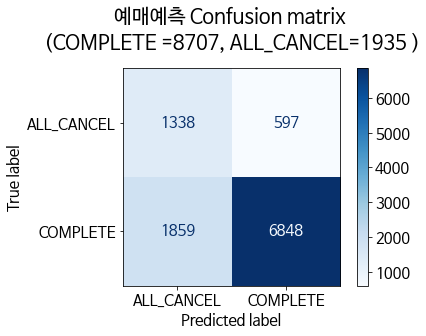

In [455]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
# 테스트데이터의 타겟 데이터
test_num = test.reserve_state_code.value_counts()

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_test, y_test,
                            cmap=plt.cm.Blues,
                            ax=ax)
plt.title(f'예매예측 Confusion matrix \n(COMPLETE ={test_num[0]}, ALL_CANCEL={test_num[1]} )', fontsize=20, pad=20)
plt.show();

**모델링 결과**
- 과적합이 발생하여 learning_rate와 n_estimators를 직접 조정하였고 과적합 문제 해소
- 성능 예측모델 77%의 정확도를 보이며, 예매취소 고객(TN)보다 예매를 취소하지 않는 고객(TP)을 더 잘 예측하도록 만들어졌다.

In [399]:
pipe.predict(X_test.iloc[[12]])

array(['COMPLETE'], dtype=object)

In [400]:
y_test.iloc[12]

'COMPLETE'

### 프로젝트 결과